## Library loading

In [1]:
import scanpy as sc, anndata as ad, numpy as np, pandas as pd
from scipy import sparse
from anndata import AnnData
import warnings
import socket
import plotly.express as px
from matplotlib import pylab
import sys
from matplotlib.colors import TwoSlopeNorm

import yaml
import os
import matplotlib.pyplot as plt
import scvelo as scv
from pybiomart import Server
import rpy2
import rpy2.robjects as ro
import seaborn as sns
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted


warnings.filterwarnings('ignore')

In [2]:
import ipynbname
nb_fname = ipynbname.name()

In [3]:
outdir="./outdir"
FinaLeaf="/Cycling"


outputBaseName = "03C_Badhuri_Cycling.3pointsModel.pBulk_byArea.scaled"


markers = "./data/resources/F_T.markers.scored.tsv"

RelevantAreas = ["pfc","temporal","somatosensory"]

groupingCovariate="cortical_area"
PseudooReplicates_per_group = 20

totalPath = outdir+FinaLeaf+"/Badhuri_cycling_pBulk.Curated."+str(PseudooReplicates_per_group)+"PRs.by"+str(groupingCovariate)+".tsv"
adataPath = outdir+FinaLeaf+"/Badhuri_cycling_pBulk.Curated."+str(PseudooReplicates_per_group)+"PRs.by"+str(groupingCovariate)+".h5ad"

In [4]:
%load_ext rpy2.ipython

In [5]:
%%R
library(edgeR)
library(org.Hs.eg.db)
library(AnnotationDbi)
library(stats)
library(topGO)

R[write to console]: Loading required package: limma

R[write to console]: Loading required package: AnnotationDbi

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following object is masked from ‘package:limma’:

    plotMA


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, 

In [6]:
%matplotlib inline

In [7]:
sc.settings.verbosity = 3         # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=50, facecolor='white')
pylab.rcParams['figure.figsize'] = (10, 10)


scanpy==1.8.1 anndata==0.7.6 umap==0.4.6 numpy==1.20.2 scipy==1.6.3 pandas==1.2.4 scikit-learn==0.24.2 statsmodels==0.13.1 python-igraph==0.9.8 louvain==0.7.1 pynndescent==0.5.5


### Configure paths

In [8]:
hostRoot = "-".join(socket.gethostname().split('-')[0:2])

with open(os.path.expanduser('~')+"/paths_config.yaml", 'r') as f:
    paths = yaml.load(f, Loader=yaml.FullLoader)

#indir=paths["paths"]["indir"][hostRoot]
#projectBaseDir=paths["paths"]["projectBaseDir"][hostRoot]



## Load ExcM  pseudobulk

In [9]:
adata = sc.read_h5ad(adataPath)

In [10]:
total = pd.read_csv(totalPath, sep="\t", index_col=0)

## Subset for relevant areas

In [11]:
adata = adata[adata.obs["group"].isin(RelevantAreas)]
#total = total[adata.obs_names]

## QCs

In [12]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata.copy()

adata.var['mt'] = adata.var_names.str.startswith('MT-')
adata.var['rb'] = adata.var_names.str.startswith(("RPS","RPL"))

adata = adata[:,~adata.var['rb']]
adata = adata[:,~adata.var['mt']]

## remove heterosomes genes

Xchr = pd.read_csv("./data/resources/X.genes.tsv", header=None)[0].tolist()
Ychr = pd.read_csv("./data/resources/Y.genes.tsv", header=None)[0].tolist()
AllHet = set(Xchr).union(set(Ychr))

sc.pp.scale(adata)


adata = adata[:,~adata.var_names.isin(AllHet)]

normalizing counts per cell
    finished (0:00:00)


In [13]:
sc.tl.pca(adata)

computing PCA
    with n_comps=50
    finished (0:00:00)


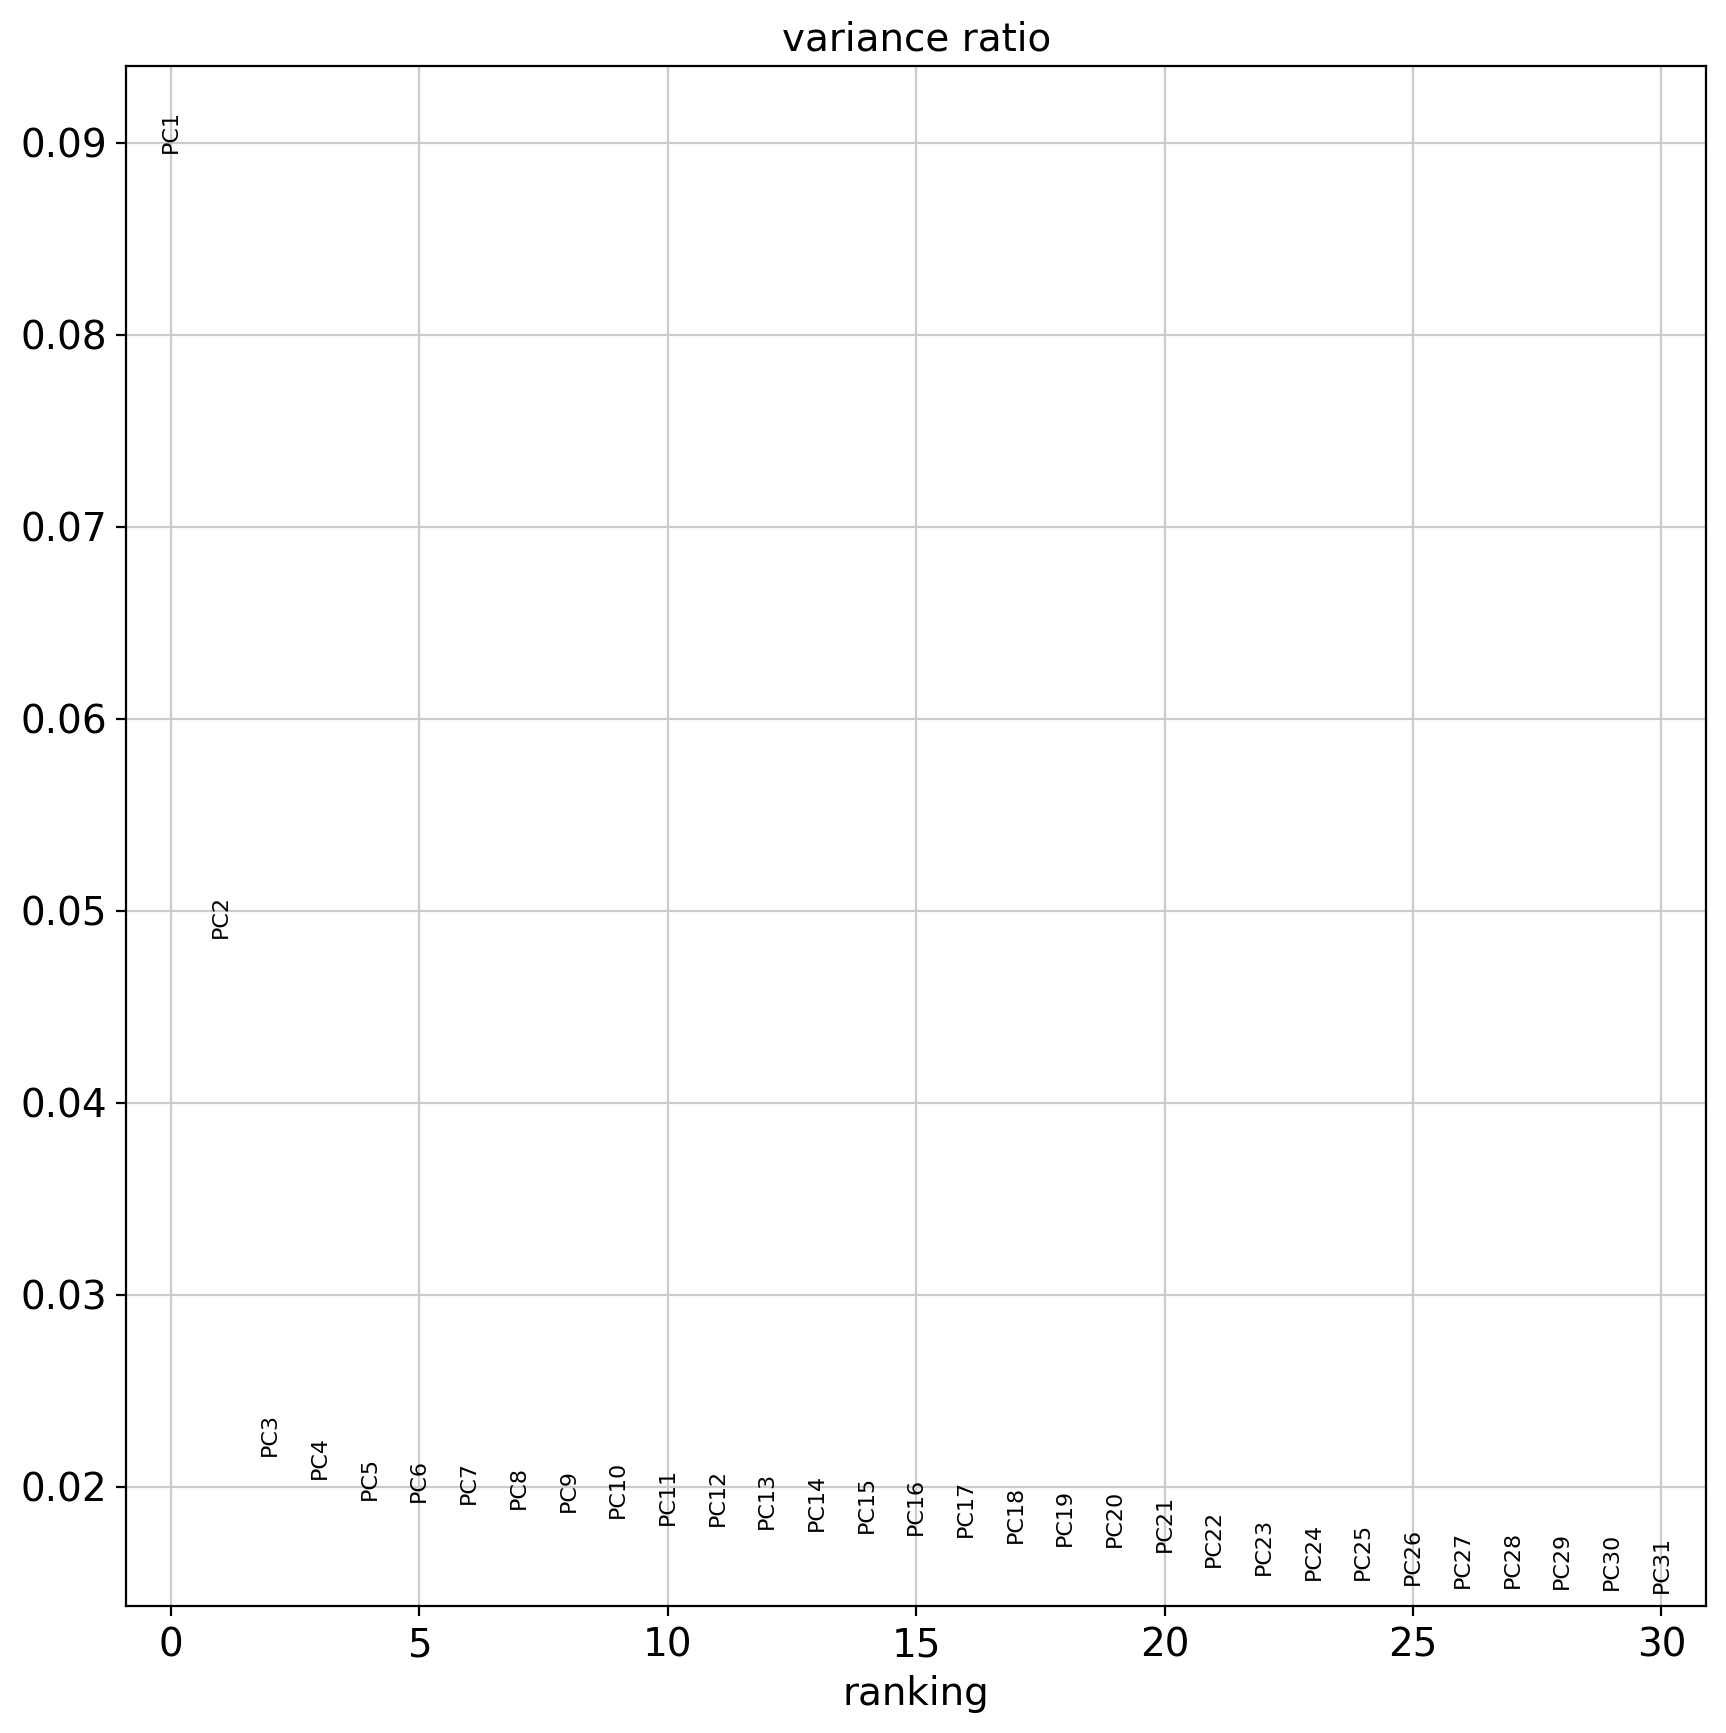

In [14]:
sc.pl.pca_variance_ratio(adata)

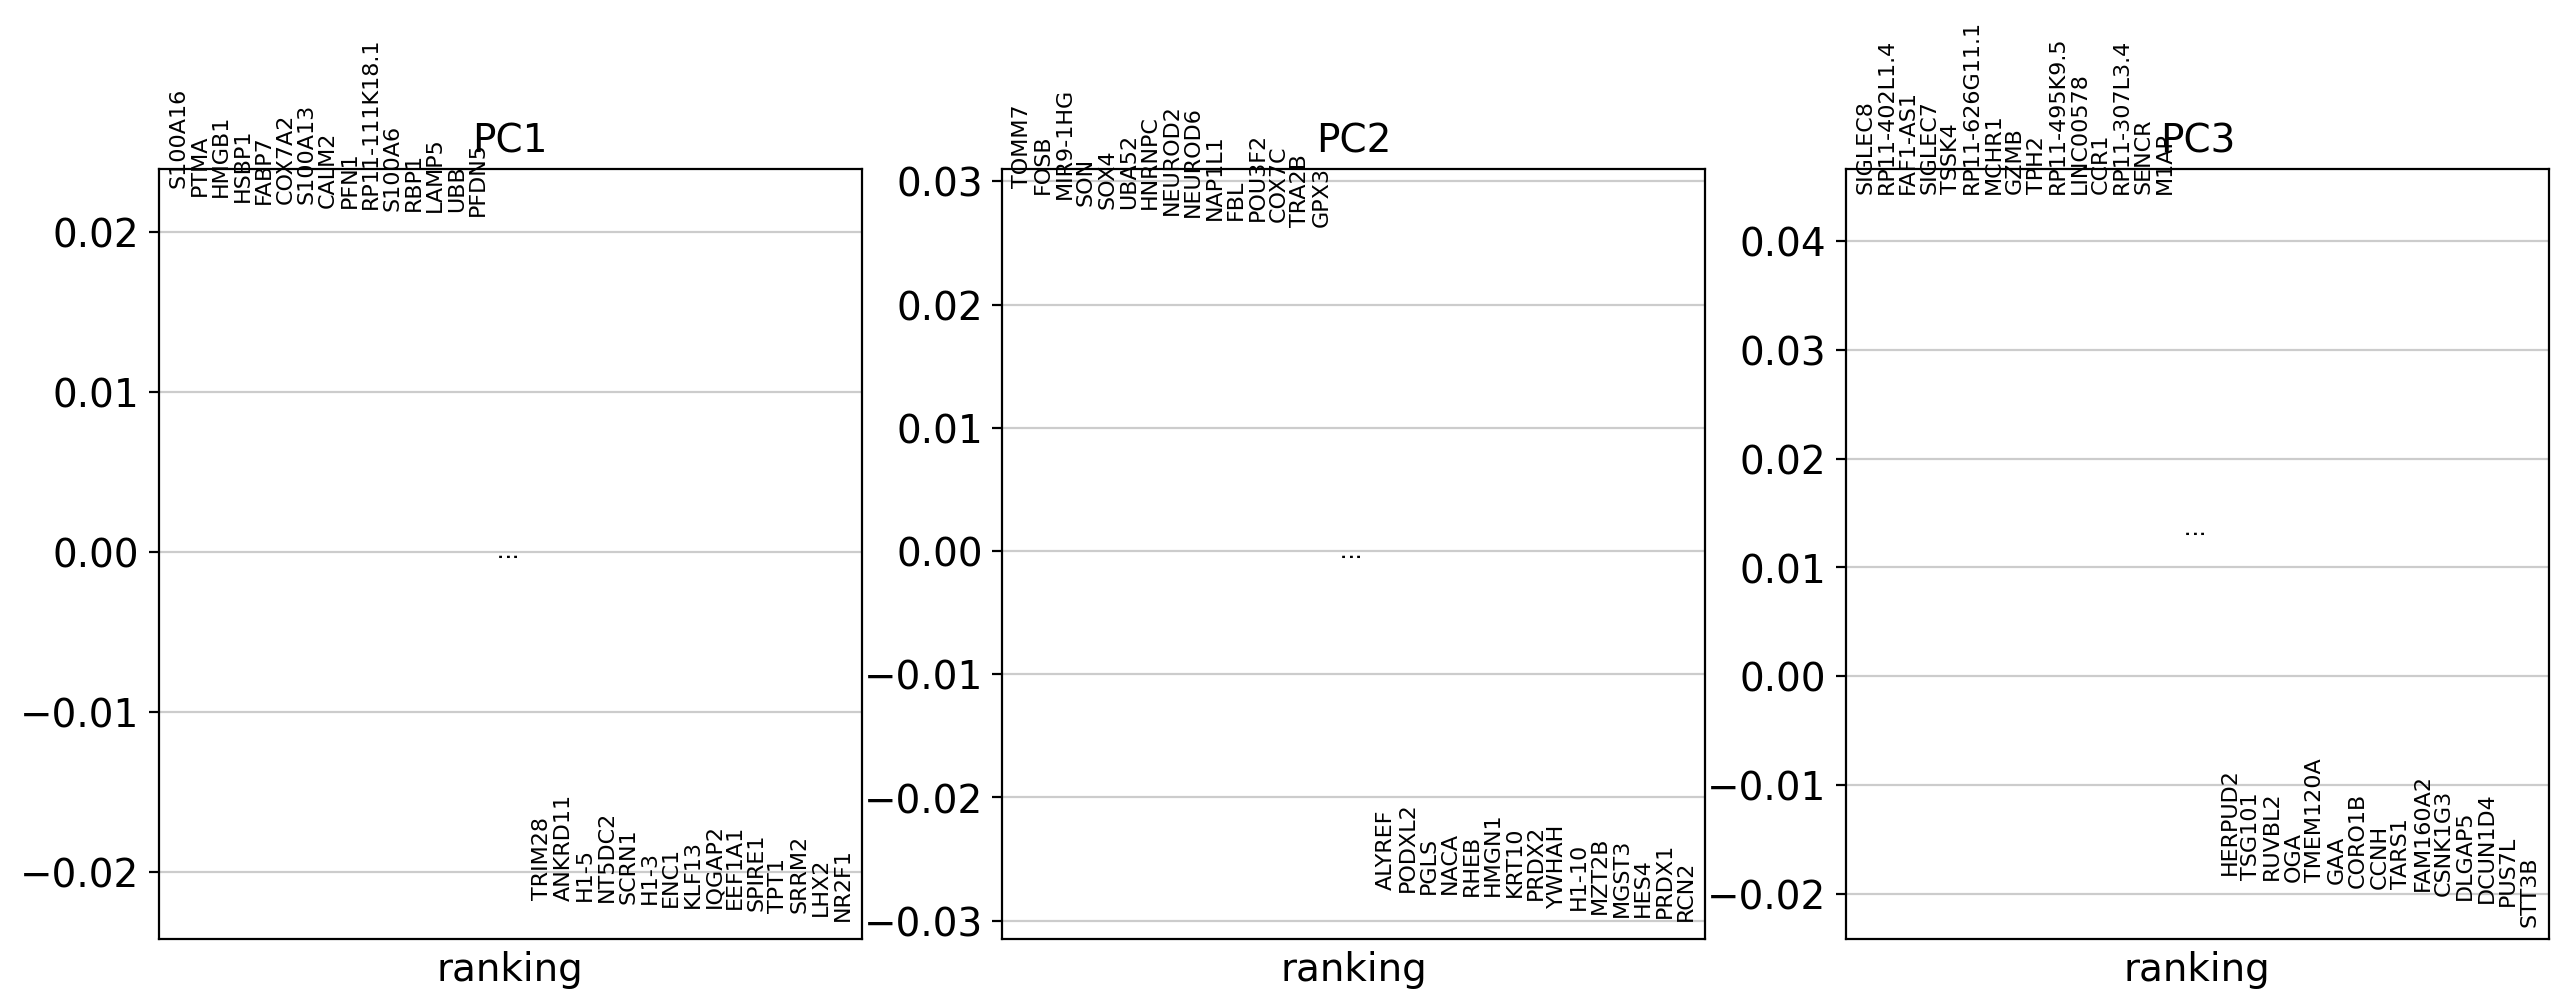

In [15]:
pylab.rcParams['figure.figsize'] = (5, 5)
sc.pl.pca_loadings(adata)
pylab.rcParams['figure.figsize'] = (10, 10)


In [16]:
n=10
CuratedList = pd.read_csv(markers, sep = "\t", header=None, names=["gene","area","evidence"])
idx = np.argpartition(adata.varm["PCs"][:,0], n)
topgenes = adata.var_names[idx[:n]]
print(topgenes)
Overlap = set(topgenes).intersection(set(CuratedList.gene))
CuratedList[CuratedList["gene"].isin(Overlap)]

Index(['NR2F1', 'SRRM2', 'LHX2', 'TPT1', 'H1-3', 'ENC1', 'KLF13', 'SPIRE1',
       'IQGAP2', 'EEF1A1'],
      dtype='object')


,gene,area,evidence
0,NR2F1,Temporal,3.0
57,LHX2,Temporal,2.0


In [17]:
idx = np.argpartition(adata.varm["PCs"][:,0], -n)
topgenes = adata.var_names[idx[-n:]]
print(topgenes)
Overlap = set(topgenes).intersection(set(CuratedList.gene))
CuratedList[CuratedList["gene"].isin(Overlap)]

Index(['RP11-111K18.1', 'PTMA', 'CALM2', 'COX7A2', 'FABP7', 'S100A13', 'PFN1',
       'HSBP1', 'HMGB1', 'S100A16'],
      dtype='object')


,gene,area,evidence
132,S100A16,Frontal,1.0
159,S100A13,Frontal,1.0
288,FABP7,Frontal,1.0


<AxesSubplot:title={'center':'group'}, xlabel='PC1', ylabel='PC2'>

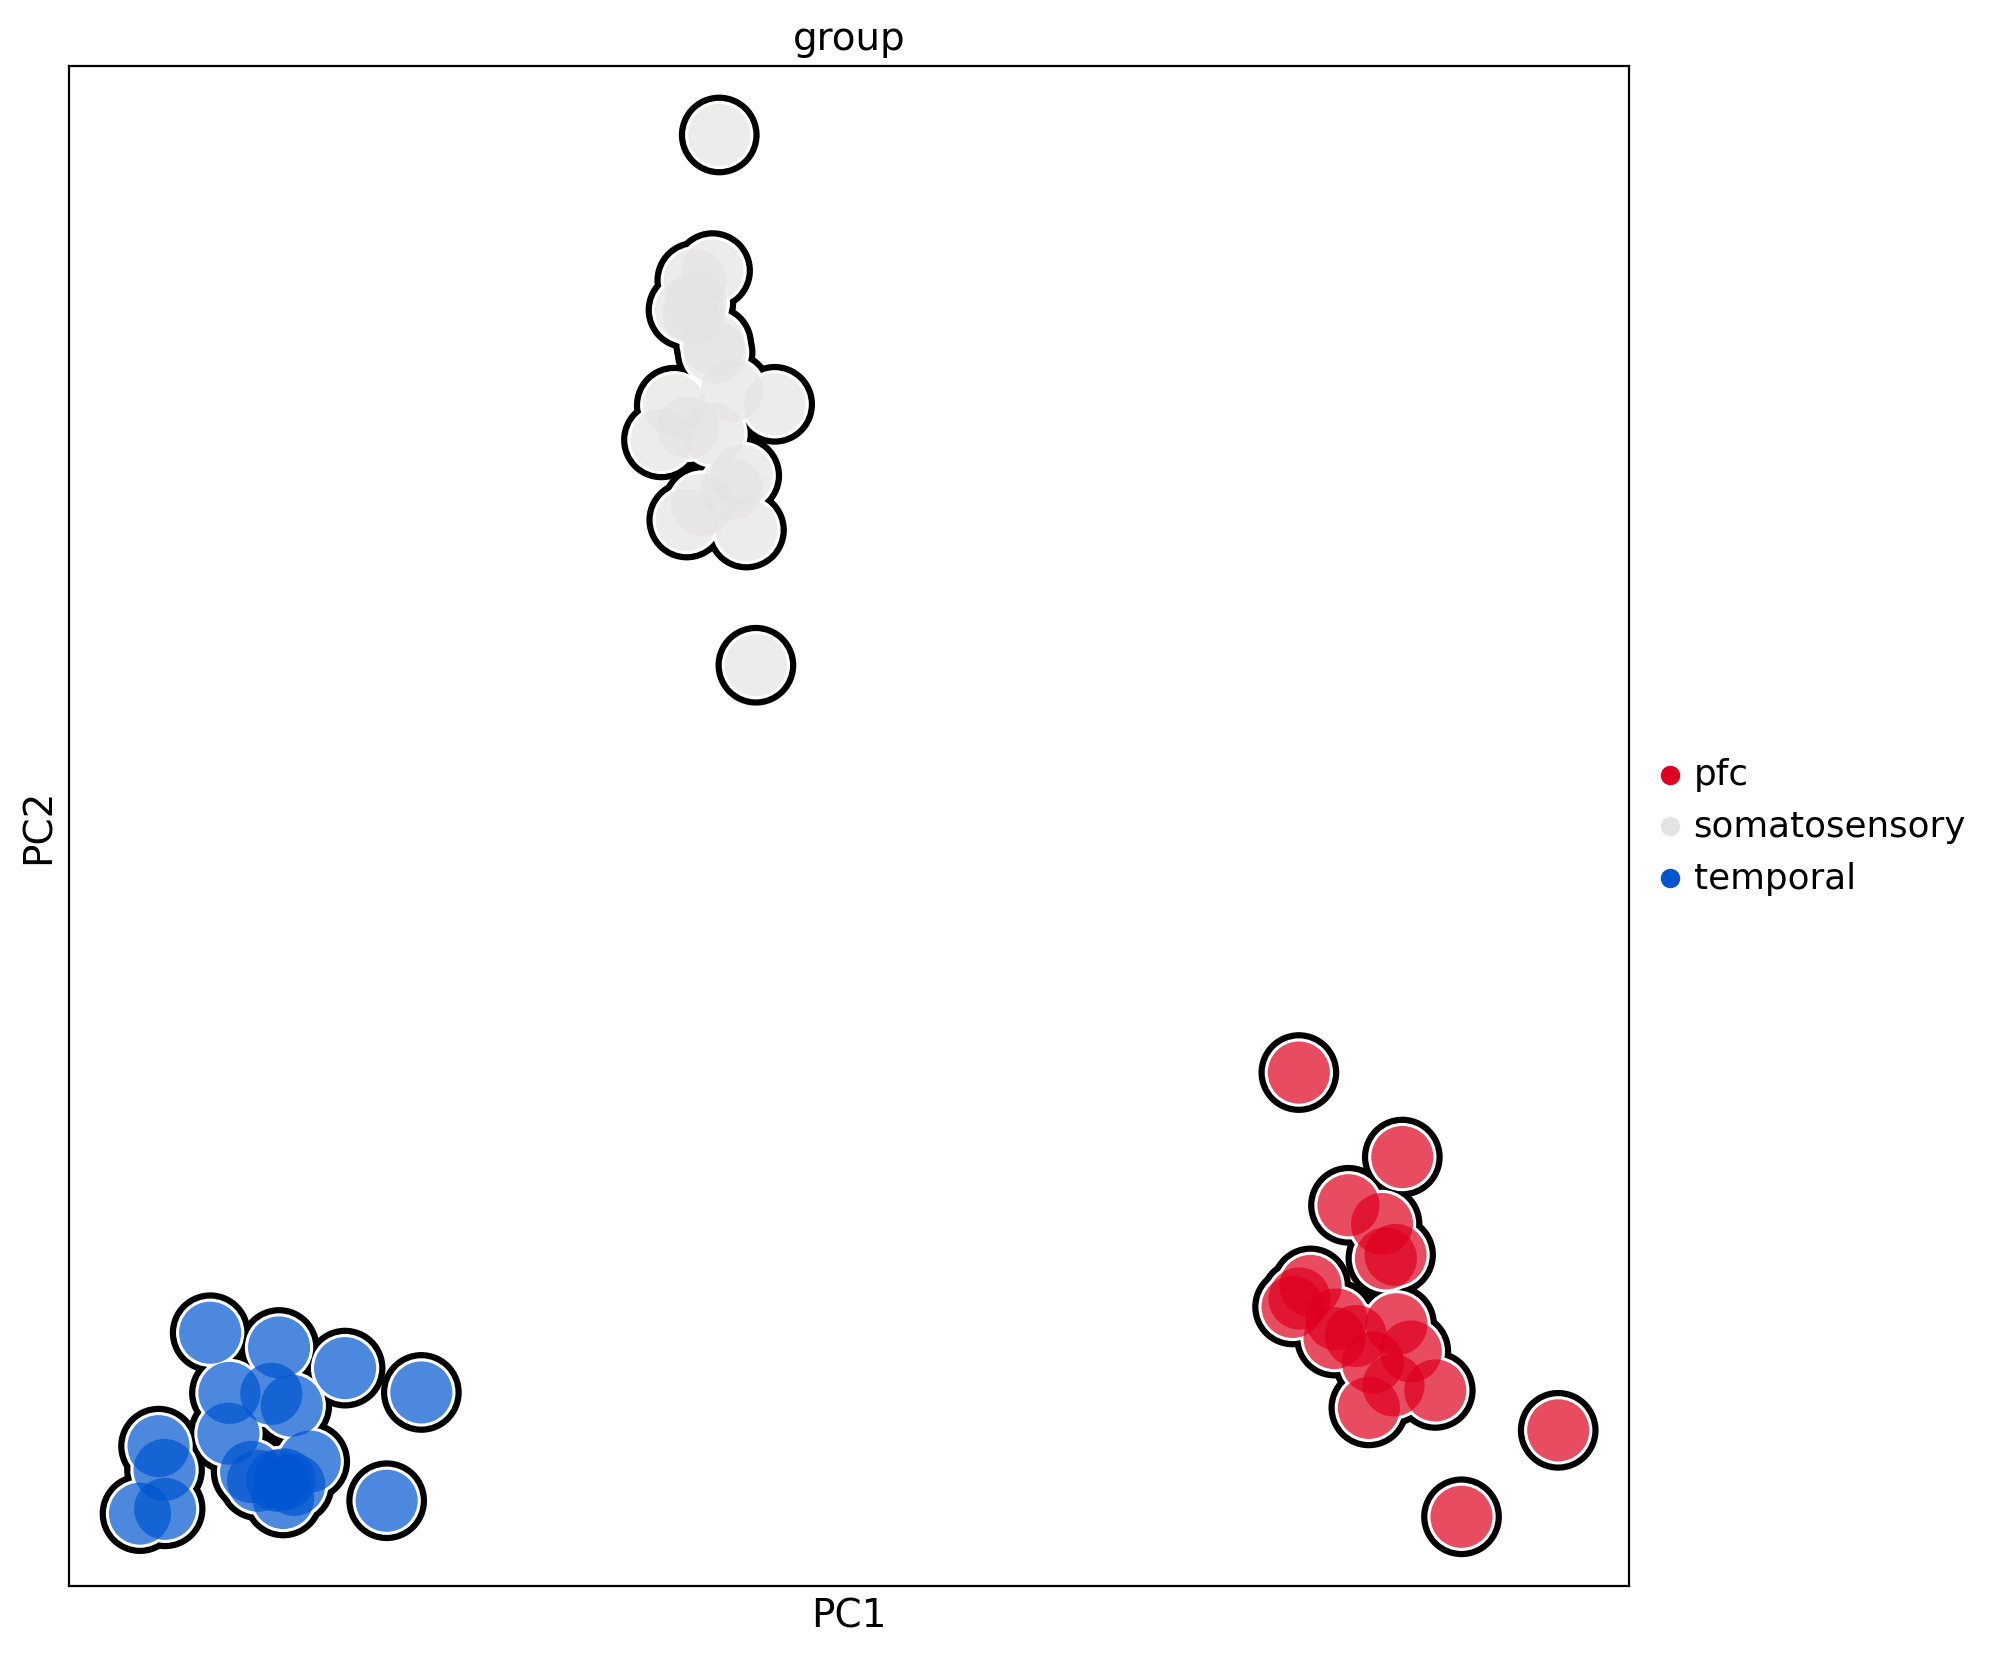

In [18]:
sc.pl.pca(adata, components=['1,2'], color=["group"], ncols=1, add_outline=True, outline_width=(.1,.05), wspace=.2, show=False)


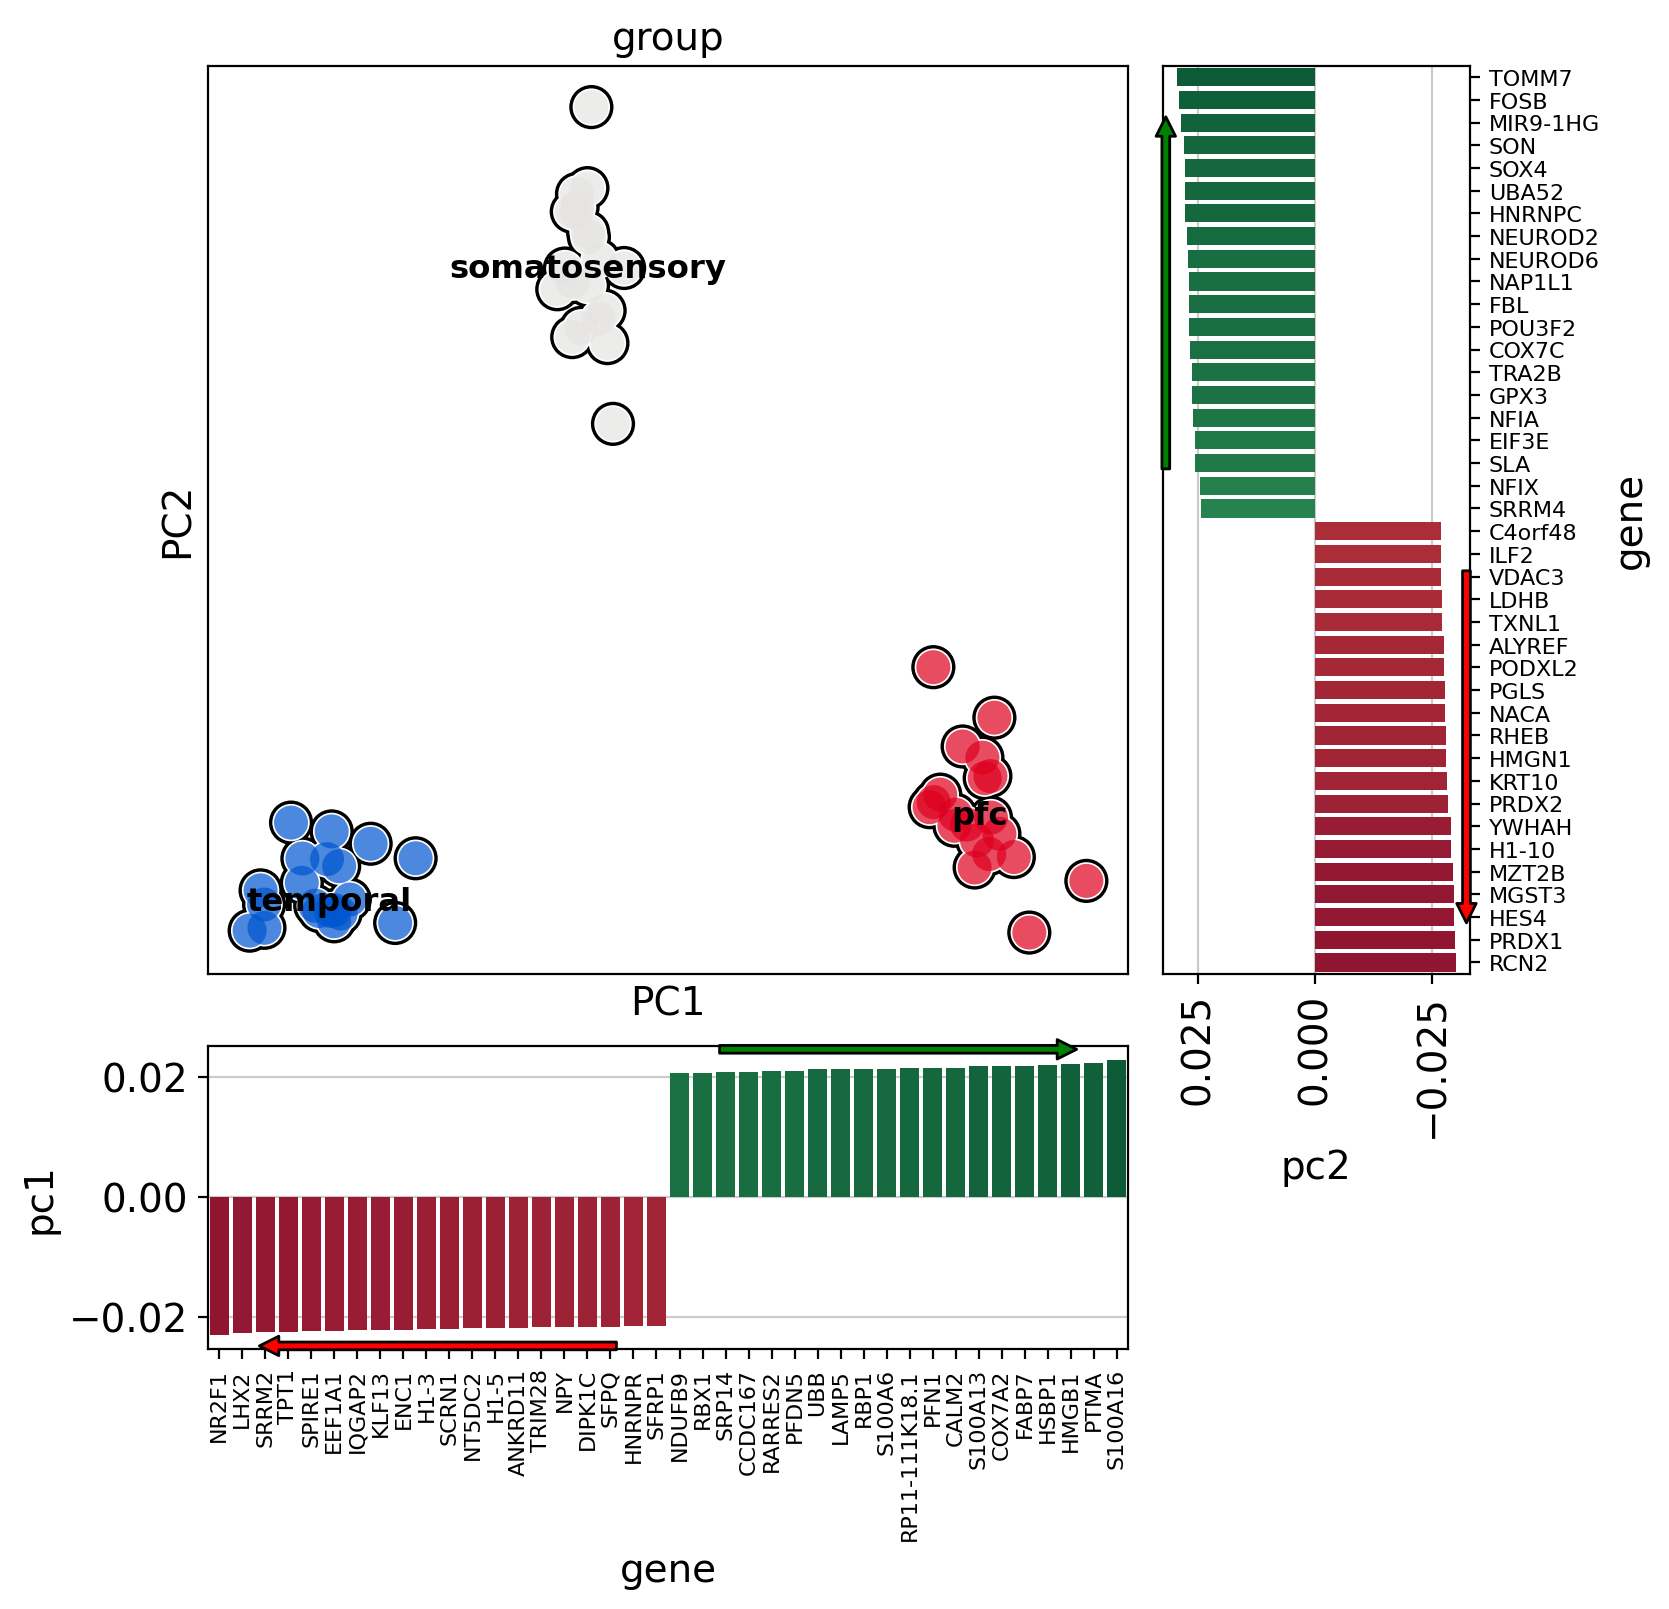

In [19]:
#if you want vector sc.settings._vector_friendly = False
vector=True
n=20
pdDict = {}
if vector:
    sc.settings._vector_friendly = False
for pc in  [0,1]:
    TopPC_IDX = np.argpartition(adata.varm["PCs"][:,pc], -n)[-n:]
    DownPC_IDX = np.argpartition(adata.varm["PCs"][:,pc], n)[:n]
    pdDict[pc] = pd.DataFrame(adata.varm["PCs"][:,pc][TopPC_IDX], index = adata.var_names[TopPC_IDX], columns=["pc"+str(pc+1)])
    pdDict[pc] = pd.concat([pdDict[pc],pd.DataFrame(adata.varm["PCs"][:,pc][DownPC_IDX], index = adata.var_names[DownPC_IDX], columns=["pc"+str(pc+1)])])
    pdDict[pc]["gene"] = pdDict[pc].index.tolist()
    if pc == 0:
        pdDict[pc] = pdDict[pc].sort_values("pc"+str(pc+1))
    elif pc == 1:
        pdDict[pc] = pdDict[pc].sort_values("pc"+str(pc+1), ascending = False)
    
    
    

figsize = (6, 6)  #(width, height)
#Set axes
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=figsize,gridspec_kw={'width_ratios': [3, 1],'height_ratios': [3, 1]})

fig.tight_layout(pad=-2, h_pad=0)   #space between plots

ax1plot = sc.pl.pca(adata, components=['1,2'], color=["group"], 
                    ncols=1, add_outline=True, legend_loc="on data",size=600,legend_fontsize="small",
                    outline_width=(.1,.05), wspace=.2, show=False, ax=ax[0][0])



norm = TwoSlopeNorm(vmin=pdDict[0]["pc1"].min(), vcenter=0, vmax=pdDict[0]["pc1"].max())
colors = [plt.cm.RdYlGn(norm(c)) for c in pdDict[0]["pc1"]]
sns.barplot(data=pdDict[0], x="gene", y="pc1", color="pc1",palette=colors,ax=ax[1][0], zorder=3 ).tick_params(axis='x', rotation=90, labelsize=8)
ax[1][0].annotate("", xy=(.95,.99),xytext=(0.55, 0.99),
                  xycoords='axes fraction',
                  arrowprops=dict(arrowstyle="simple",facecolor="green"))
ax[1][0].annotate("", xy=(.05,.01),xytext=(0.45, 0.01),
                  xycoords='axes fraction',
                  arrowprops=dict(arrowstyle="simple",facecolor="red"))


norm = TwoSlopeNorm(vmin=pdDict[1]["pc2"].min(), vcenter=0, vmax=pdDict[1]["pc2"].max())
colors = [plt.cm.RdYlGn(norm(c)) for c in pdDict[1]["pc2"]]
sns.barplot(data=pdDict[1], x="pc2", y="gene", color="pc2",palette=colors,ax=ax[0][1], zorder=3 ).tick_params(axis='y',  
                                                                                                              labelsize=8, 
                                                                                                              labelright=True, labelleft=False,
                                                                                                              right=True, left=False)
ax[0][1].tick_params(axis='x', rotation=90)

ax[0][1].annotate("", xy=(.01,.95),xytext=(0.01, 0.55),
                  xycoords='axes fraction',
                  arrowprops=dict(arrowstyle="simple",facecolor="green"))
ax[0][1].annotate("", xy=(.99,.05),xytext=(0.99, 0.45),
                  xycoords='axes fraction',
                  arrowprops=dict(arrowstyle="simple",facecolor="red"))



ax[0][1].invert_xaxis()
ax[0][1].yaxis.set_label_position("right")
fig.delaxes(ax[1][1])

sc.settings._vector_friendly = True

In [20]:
import ipynbname
nb_fname = ipynbname.name()

In [21]:
fig.savefig("./figures/"+nb_fname+".PCA.pdf",
           bbox_inches="tight")

# Save top 50 PCA loadings

In [22]:
n=50
pdDict = {}
for pc in  [0,1]:
    TopPC_IDX = np.argpartition(adata.varm["PCs"][:,pc], -n)[-n:]
    DownPC_IDX = np.argpartition(adata.varm["PCs"][:,pc], n)[:n]
    pdDict[pc] = pd.DataFrame(adata.varm["PCs"][:,pc][TopPC_IDX], index = adata.var_names[TopPC_IDX], columns=["variance"])
    pdDict[pc] = pd.concat([pdDict[pc],pd.DataFrame(adata.varm["PCs"][:,pc][DownPC_IDX], index = adata.var_names[DownPC_IDX], columns=["variance"])])
    pdDict[pc]["gene"] = pdDict[pc].index.tolist()
    if pc == 0:
        pdDict[pc] = pdDict[pc].sort_values("variance")
    elif pc == 1:
        pdDict[pc] = pdDict[pc].sort_values("variance", ascending = False)
    pdDict[pc]["component"] = "pc"+str(pc+1)
    
pd.concat([pdDict[0],pdDict[1]]).to_excel(outdir+"/"+FinaLeaf+"/"+nb_fname+".topLoadings.xls")

# Badhuri dotplot

In [23]:
badhuriMarkers = ["PAX6","DDIT3","NEUROG2","CNBP","HMGB2","ZNF707","CAMTA1","SUB1","THYN1","NEUROG1","NFIX","BCL11A","TCF4","NR2F1"]

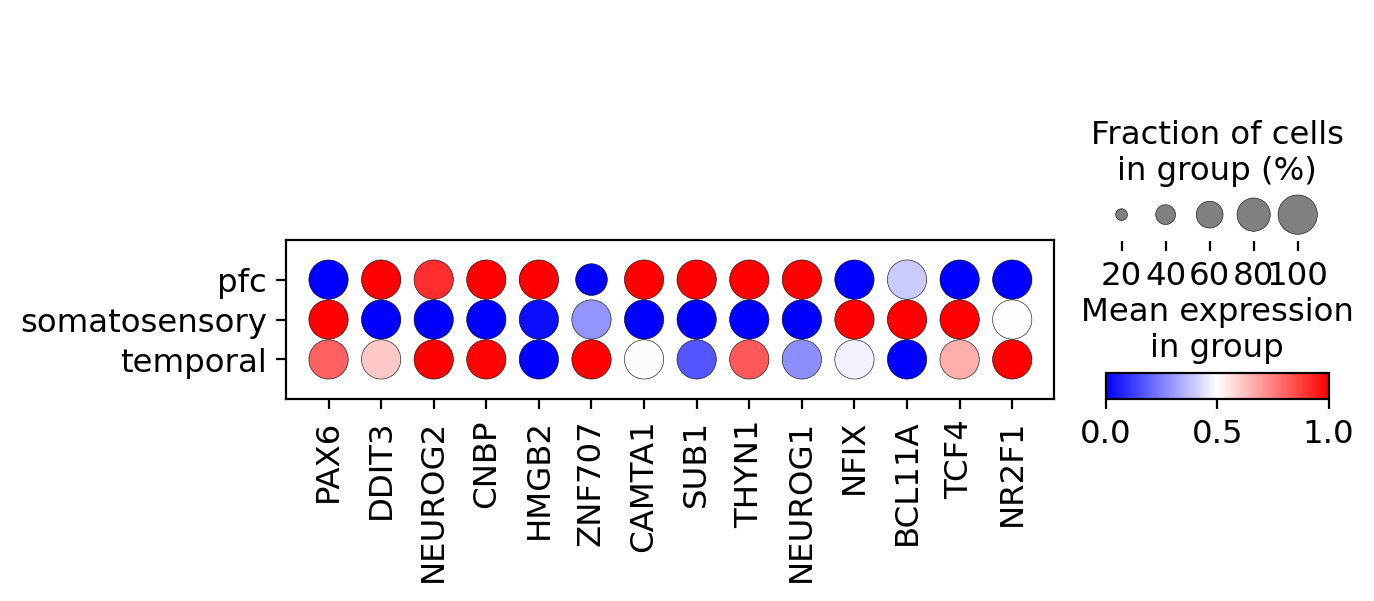

In [24]:
sc.pl.dotplot(adata, badhuriMarkers, 'group', dendrogram=False,cmap='bwr',use_raw =True,standard_scale ="var")

# Badhuri dotplot (no SS)

In [25]:
badhuriMarkers = ["PAX6","DDIT3","NEUROG2","CNBP","HMGB2","ZNF707","CAMTA1","SUB1","THYN1","NEUROG1","NFIX","BCL11A","TCF4","NR2F1"]

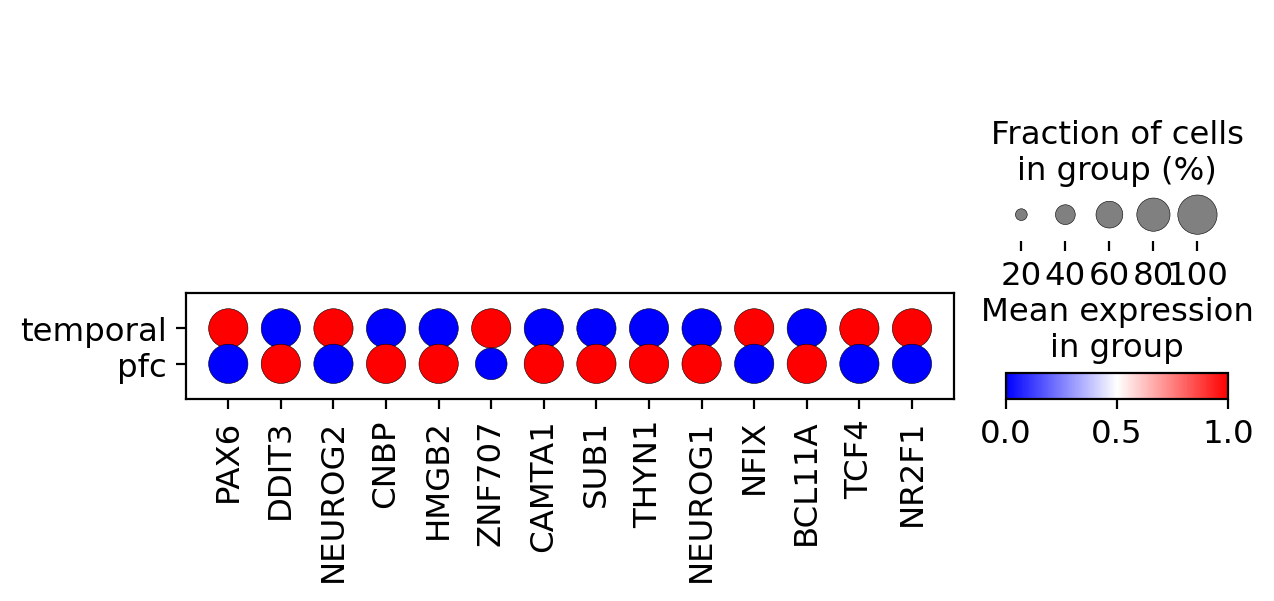

In [26]:
sc.pl.dotplot(adata[adata.obs["group"] != "somatosensory"], badhuriMarkers, 'group', dendrogram=False,cmap='bwr',use_raw =True,standard_scale ="var", categories_order=["temporal","pfc"])

## DEA

### RPY INITIALIZATION

In [27]:
edgeR_topTags = ro.r['topTags']
edgeR_glmLRT = ro.r['glmLRT']
edgeR_glmQLFTest = ro.r['glmQLFTest']
as_data_frame = ro.r['as.data.frame']
rprint = rpy2.robjects.globalenv.find("print")

In [28]:
DEGs = {}
TestCov = "group"

In [29]:
adata.obs

,group,pseudoreplicate,number_of_cell,brain_region,tissue_ontology_term_id,assay_ontology_term_id,disease_ontology_term_id,cell_type_ontology_term_id,ethnicity_ontology_term_id,organism_ontology_term_id,...,cell_type,assay,disease,organism,sex,tissue,ethnicity,cluster_label_aggr,cluster_label_area,cluster_label_area_layers
pfc_0,pfc,0.0,171.0,neocortex,UBERON:0000451,EFO:0009899,PATO:0000461,CL:0000003,unknown,NCBITaxon:9606,...,native cell,10x 3' v2,normal,Homo sapiens,unknown,prefrontal cortex,unknown,dividing,dividing_pfc,dividing_pfc
pfc_1,pfc,1.0,171.0,neocortex,UBERON:0000451,EFO:0009899,PATO:0000461,CL:0000003,unknown,NCBITaxon:9606,...,native cell,10x 3' v2,normal,Homo sapiens,unknown,prefrontal cortex,unknown,dividing,dividing_pfc,dividing_pfc
pfc_2,pfc,2.0,171.0,neocortex,UBERON:0000451,EFO:0009899,PATO:0000461,CL:0000003,unknown,NCBITaxon:9606,...,native cell,10x 3' v2,normal,Homo sapiens,unknown,prefrontal cortex,unknown,dividing,dividing_pfc,dividing_pfc
pfc_3,pfc,3.0,170.0,neocortex,UBERON:0000451,EFO:0009899,PATO:0000461,CL:0000003,unknown,NCBITaxon:9606,...,native cell,10x 3' v2,normal,Homo sapiens,unknown,prefrontal cortex,unknown,dividing,dividing_pfc,dividing_pfc
pfc_4,pfc,4.0,170.0,neocortex,UBERON:0000451,EFO:0009899,PATO:0000461,CL:0000003,unknown,NCBITaxon:9606,...,native cell,10x 3' v2,normal,Homo sapiens,unknown,prefrontal cortex,unknown,dividing,dividing_pfc,dividing_pfc
pfc_5,pfc,5.0,170.0,neocortex,UBERON:0000451,EFO:0009899,PATO:0000461,CL:0000003,unknown,NCBITaxon:9606,...,native cell,10x 3' v2,normal,Homo sapiens,unknown,prefrontal cortex,unknown,dividing,dividing_pfc,dividing_pfc
pfc_6,pfc,6.0,170.0,neocortex,UBERON:0000451,EFO:0009899,PATO:0000461,CL:0000003,unknown,NCBITaxon:9606,...,native cell,10x 3' v2,normal,Homo sapiens,unknown,prefrontal cortex,unknown,dividing,dividing_pfc,dividing_pfc
pfc_7,pfc,7.0,170.0,neocortex,UBERON:0000451,EFO:0009899,PATO:0000461,CL:0000003,unknown,NCBITaxon:9606,...,native cell,10x 3' v2,normal,Homo sapiens,unknown,prefrontal cortex,unknown,dividing,dividing_pfc,dividing_pfc
pfc_8,pfc,8.0,170.0,neocortex,UBERON:0000451,EFO:0009899,PATO:0000461,CL:0000003,unknown,NCBITaxon:9606,...,native cell,10x 3' v2,normal,Homo sapiens,unknown,prefrontal cortex,unknown,dividing,dividing_pfc,dividing_pfc
pfc_9,pfc,9.0,170.0,neocortex,UBERON:0000451,EFO:0009899,PATO:0000461,CL:0000003,unknown,NCBITaxon:9606,...,native cell,10x 3' v2,normal,Homo sapiens,unknown,prefrontal cortex,unknown,dividing,dividing_pfc,dividing_pfc


### MM

In [30]:
adata.obs

,group,pseudoreplicate,number_of_cell,brain_region,tissue_ontology_term_id,assay_ontology_term_id,disease_ontology_term_id,cell_type_ontology_term_id,ethnicity_ontology_term_id,organism_ontology_term_id,...,cell_type,assay,disease,organism,sex,tissue,ethnicity,cluster_label_aggr,cluster_label_area,cluster_label_area_layers
pfc_0,pfc,0.0,171.0,neocortex,UBERON:0000451,EFO:0009899,PATO:0000461,CL:0000003,unknown,NCBITaxon:9606,...,native cell,10x 3' v2,normal,Homo sapiens,unknown,prefrontal cortex,unknown,dividing,dividing_pfc,dividing_pfc
pfc_1,pfc,1.0,171.0,neocortex,UBERON:0000451,EFO:0009899,PATO:0000461,CL:0000003,unknown,NCBITaxon:9606,...,native cell,10x 3' v2,normal,Homo sapiens,unknown,prefrontal cortex,unknown,dividing,dividing_pfc,dividing_pfc
pfc_2,pfc,2.0,171.0,neocortex,UBERON:0000451,EFO:0009899,PATO:0000461,CL:0000003,unknown,NCBITaxon:9606,...,native cell,10x 3' v2,normal,Homo sapiens,unknown,prefrontal cortex,unknown,dividing,dividing_pfc,dividing_pfc
pfc_3,pfc,3.0,170.0,neocortex,UBERON:0000451,EFO:0009899,PATO:0000461,CL:0000003,unknown,NCBITaxon:9606,...,native cell,10x 3' v2,normal,Homo sapiens,unknown,prefrontal cortex,unknown,dividing,dividing_pfc,dividing_pfc
pfc_4,pfc,4.0,170.0,neocortex,UBERON:0000451,EFO:0009899,PATO:0000461,CL:0000003,unknown,NCBITaxon:9606,...,native cell,10x 3' v2,normal,Homo sapiens,unknown,prefrontal cortex,unknown,dividing,dividing_pfc,dividing_pfc
pfc_5,pfc,5.0,170.0,neocortex,UBERON:0000451,EFO:0009899,PATO:0000461,CL:0000003,unknown,NCBITaxon:9606,...,native cell,10x 3' v2,normal,Homo sapiens,unknown,prefrontal cortex,unknown,dividing,dividing_pfc,dividing_pfc
pfc_6,pfc,6.0,170.0,neocortex,UBERON:0000451,EFO:0009899,PATO:0000461,CL:0000003,unknown,NCBITaxon:9606,...,native cell,10x 3' v2,normal,Homo sapiens,unknown,prefrontal cortex,unknown,dividing,dividing_pfc,dividing_pfc
pfc_7,pfc,7.0,170.0,neocortex,UBERON:0000451,EFO:0009899,PATO:0000461,CL:0000003,unknown,NCBITaxon:9606,...,native cell,10x 3' v2,normal,Homo sapiens,unknown,prefrontal cortex,unknown,dividing,dividing_pfc,dividing_pfc
pfc_8,pfc,8.0,170.0,neocortex,UBERON:0000451,EFO:0009899,PATO:0000461,CL:0000003,unknown,NCBITaxon:9606,...,native cell,10x 3' v2,normal,Homo sapiens,unknown,prefrontal cortex,unknown,dividing,dividing_pfc,dividing_pfc
pfc_9,pfc,9.0,170.0,neocortex,UBERON:0000451,EFO:0009899,PATO:0000461,CL:0000003,unknown,NCBITaxon:9606,...,native cell,10x 3' v2,normal,Homo sapiens,unknown,prefrontal cortex,unknown,dividing,dividing_pfc,dividing_pfc


In [31]:
RelevantAreas = ["pfc","temporal","somatosensory"]
obs = adata.obs[["pseudoreplicate",TestCov]].copy()
obs["pseudoreplicate"] = obs.index.tolist()
obs["TestCov"] = obs[TestCov]

RelevantAreasPattern = np.array([1,2,3])
RelevantAreasPattern = RelevantAreasPattern/RelevantAreasPattern.sum()
dictionary = {"temporal":RelevantAreasPattern[0],"somatosensory":RelevantAreasPattern[1],"pfc":RelevantAreasPattern[2] }
obs["TestCov"] = obs.TestCov.replace(dictionary)
#obs["TestCov"] = obs[TestCov]

In [32]:
obs["TestCov"]

pfc_0               0.500000
pfc_1               0.500000
pfc_2               0.500000
pfc_3               0.500000
pfc_4               0.500000
pfc_5               0.500000
pfc_6               0.500000
pfc_7               0.500000
pfc_8               0.500000
pfc_9               0.500000
pfc_10              0.500000
pfc_11              0.500000
pfc_12              0.500000
pfc_13              0.500000
pfc_14              0.500000
pfc_15              0.500000
pfc_16              0.500000
pfc_17              0.500000
pfc_18              0.500000
pfc_19              0.500000
somatosensory_0     0.333333
somatosensory_1     0.333333
somatosensory_2     0.333333
somatosensory_3     0.333333
somatosensory_4     0.333333
somatosensory_5     0.333333
somatosensory_6     0.333333
somatosensory_7     0.333333
somatosensory_8     0.333333
somatosensory_9     0.333333
somatosensory_10    0.333333
somatosensory_11    0.333333
somatosensory_12    0.333333
somatosensory_13    0.333333
somatosensory_

### Counts

In [33]:
totalRelevant = total[obs.index].copy()

In [34]:
#totalRelevant = totalRelevant.loc[adata.var_names.intersection(totalRelevant.index)]

In [35]:
minCounts = totalRelevant[totalRelevant > 0].min(axis = 1).min()

#Universe 1 count in at least 5% of samples per group
groupThreshold = round(pd.get_dummies(obs[TestCov]).T.sum(axis = 1) *0.05)
bolMatrix = (np.matrix(np.dot(pd.get_dummies(obs[TestCov]).T, (totalRelevant > 0).astype(int).T)) - np.matrix(groupThreshold).T > 0)
bolVect = (bolMatrix.sum(axis = 0) >= 1).A1
totalRelevant = totalRelevant.loc[bolVect]
len(totalRelevant)

18367

In [36]:
universe = totalRelevant.loc[adata.var_names.intersection(totalRelevant.index)].index.tolist()

In [37]:
%%R -i obs -i totalRelevant -o dds 

mm <- model.matrix(~obs$TestCov )
row.names(mm) <- colnames(totalRelevant)

dds <- DGEList(totalRelevant, group = obs$TestCov, genes = rownames(totalRelevant))

#Ennotate with entrez genes
anno <- select(org.Hs.eg.db, keys=rownames(dds$counts),columns=c("ENTREZID","SYMBOL"),keytype="SYMBOL")
colnames(anno) <- c("genes","entrez")
anno <- anno[!duplicated(anno$genes, fromLast=T), ]
dds$genes$entrez <- merge(x = data.frame(dds$genes), y = anno, by = "genes", all.x = TRUE)$entrez

dim(dds)

R[write to console]: 'select()' returned 1:many mapping between keys and columns



[1] 18367    60


coefficient changes > logFC

In [38]:
%%R

mm

                 (Intercept) obs$TestCov
pfc_0                      1   0.5000000
pfc_1                      1   0.5000000
pfc_2                      1   0.5000000
pfc_3                      1   0.5000000
pfc_4                      1   0.5000000
pfc_5                      1   0.5000000
pfc_6                      1   0.5000000
pfc_7                      1   0.5000000
pfc_8                      1   0.5000000
pfc_9                      1   0.5000000
pfc_10                     1   0.5000000
pfc_11                     1   0.5000000
pfc_12                     1   0.5000000
pfc_13                     1   0.5000000
pfc_14                     1   0.5000000
pfc_15                     1   0.5000000
pfc_16                     1   0.5000000
pfc_17                     1   0.5000000
pfc_18                     1   0.5000000
pfc_19                     1   0.5000000
somatosensory_0            1   0.3333333
somatosensory_1            1   0.3333333
somatosensory_2            1   0.3333333
somatosensory_3 

In [39]:
%%R -i minCounts

#keep <- filterByExpr(dds, min.count = minCounts, min.total.count = minCounts*5)
#dds <- dds[keep,,keep.lib.sizes=FALSE]
dim(dds)

[1] 18367    60


In [40]:
%%R
dds <- calcNormFactors(dds)
dds <- estimateGLMRobustDisp(dds, mm)
fit <- glmFit(dds, mm)

In [41]:
%%R -i universe

fit <- fit[which(rownames(fit) %in% universe),]


In [42]:
%%R -o PFC_vs_Temporal -o cpm
#-o Mid_vs_early -o Late_vs_mid
topn=10000
PFC_vs_Temporal = topTags(glmLRT(fit, coef=2), adjust.method = "bonferroni", p.value = 0.001, n = topn, sort.by = "p.value")
cpm = cpm(fit, log=TRUE)
#Temporal_vs_Visual = topTags(glmLRT(fit, contrast=c(0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1)), adjust.method = "fdr", p.value = 0.01, n = topn, sort.by = "logFC")
#Late_vs_mid = topTags(glmLRT(fit, contrast=(0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,-1)), adjust.method = "fdr", p.value = 0.01, n = 500, sort.by = "logFC")


In [43]:
FDRTHREHSOLD = 2

PFC_vs_Temporaldf = rpy2.robjects.pandas2ri.rpy2py(as_data_frame(PFC_vs_Temporal))

#Temporal_vs_PFCdf_filtered = Temporal_vs_PFCdf[Temporal_vs_PFCdf.logFC.abs() >= FDRTHREHSOLD]
#Temporal_vs_PFClist_filtered = Temporal_vs_PFCdf_filtered.index.tolist()

#Temporal_vs_PFCdf_filtered

In [44]:
PFC_vs_Temporaldf
# Diff o mean
# prioritize according to number of cells

,genes,entrez,logFC,logCPM,LR,PValue,FWER
NR2F1,NR2F1,7458,-7.661204,7.921461,2245.214204,0.000000e+00,0.000000e+00
PTMA,PTMA,80254,1.608303,12.682212,728.024801,2.408216e-160,4.259412e-156
HMGB1,HMGB1,23659,1.109050,12.364849,669.818096,1.094370e-147,1.935612e-143
S100A16,S100A16,369,10.492386,5.008513,666.341510,6.240536e-147,1.103764e-142
NR2F2,NR2F2,6013,-17.726750,4.643613,625.162267,5.636251e-138,9.968837e-134
...,...,...,...,...,...,...,...
C1orf50,C1orf50,11096,1.993106,4.902615,29.517432,5.541602e-08,9.801432e-04
CREB3L1,CREB3L1,23038,-9.253979,2.264223,29.516887,5.543163e-08,9.804192e-04
USP13,USP13,None,-1.978830,4.957355,29.516444,5.544430e-08,9.806434e-04
KDM2A,KDM2A,4331,-1.812645,5.202682,29.510404,5.561734e-08,9.837039e-04


In [45]:
posTrends = PFC_vs_Temporaldf[PFC_vs_Temporaldf.logFC > 0]
negTrends = PFC_vs_Temporaldf[PFC_vs_Temporaldf.logFC < 0]


In [46]:
PFC_vs_Temporaldf
PFC_vs_Temporaldf_filtered = PFC_vs_Temporaldf.copy()
PFC_vs_TemporalList_filtered = PFC_vs_Temporaldf_filtered.index.tolist()

# Check overlap between the curated list and the genes resulting from DEA

In [47]:
markersDF = pd.read_csv(markers, header=None, sep = "\t", names=["name","area","score"])
markersDF.shape

(290, 3)

In [48]:
temporalDEGs = PFC_vs_Temporaldf[PFC_vs_Temporaldf.logFC < 0].index.tolist()
frontalDEGs = PFC_vs_Temporaldf[PFC_vs_Temporaldf.logFC > 0].index.tolist()

temporalMarkers = markersDF.loc[markersDF["area"] == "Temporal","name"]
frontalMarkers = markersDF.loc[markersDF["area"] == "Frontal","name"]

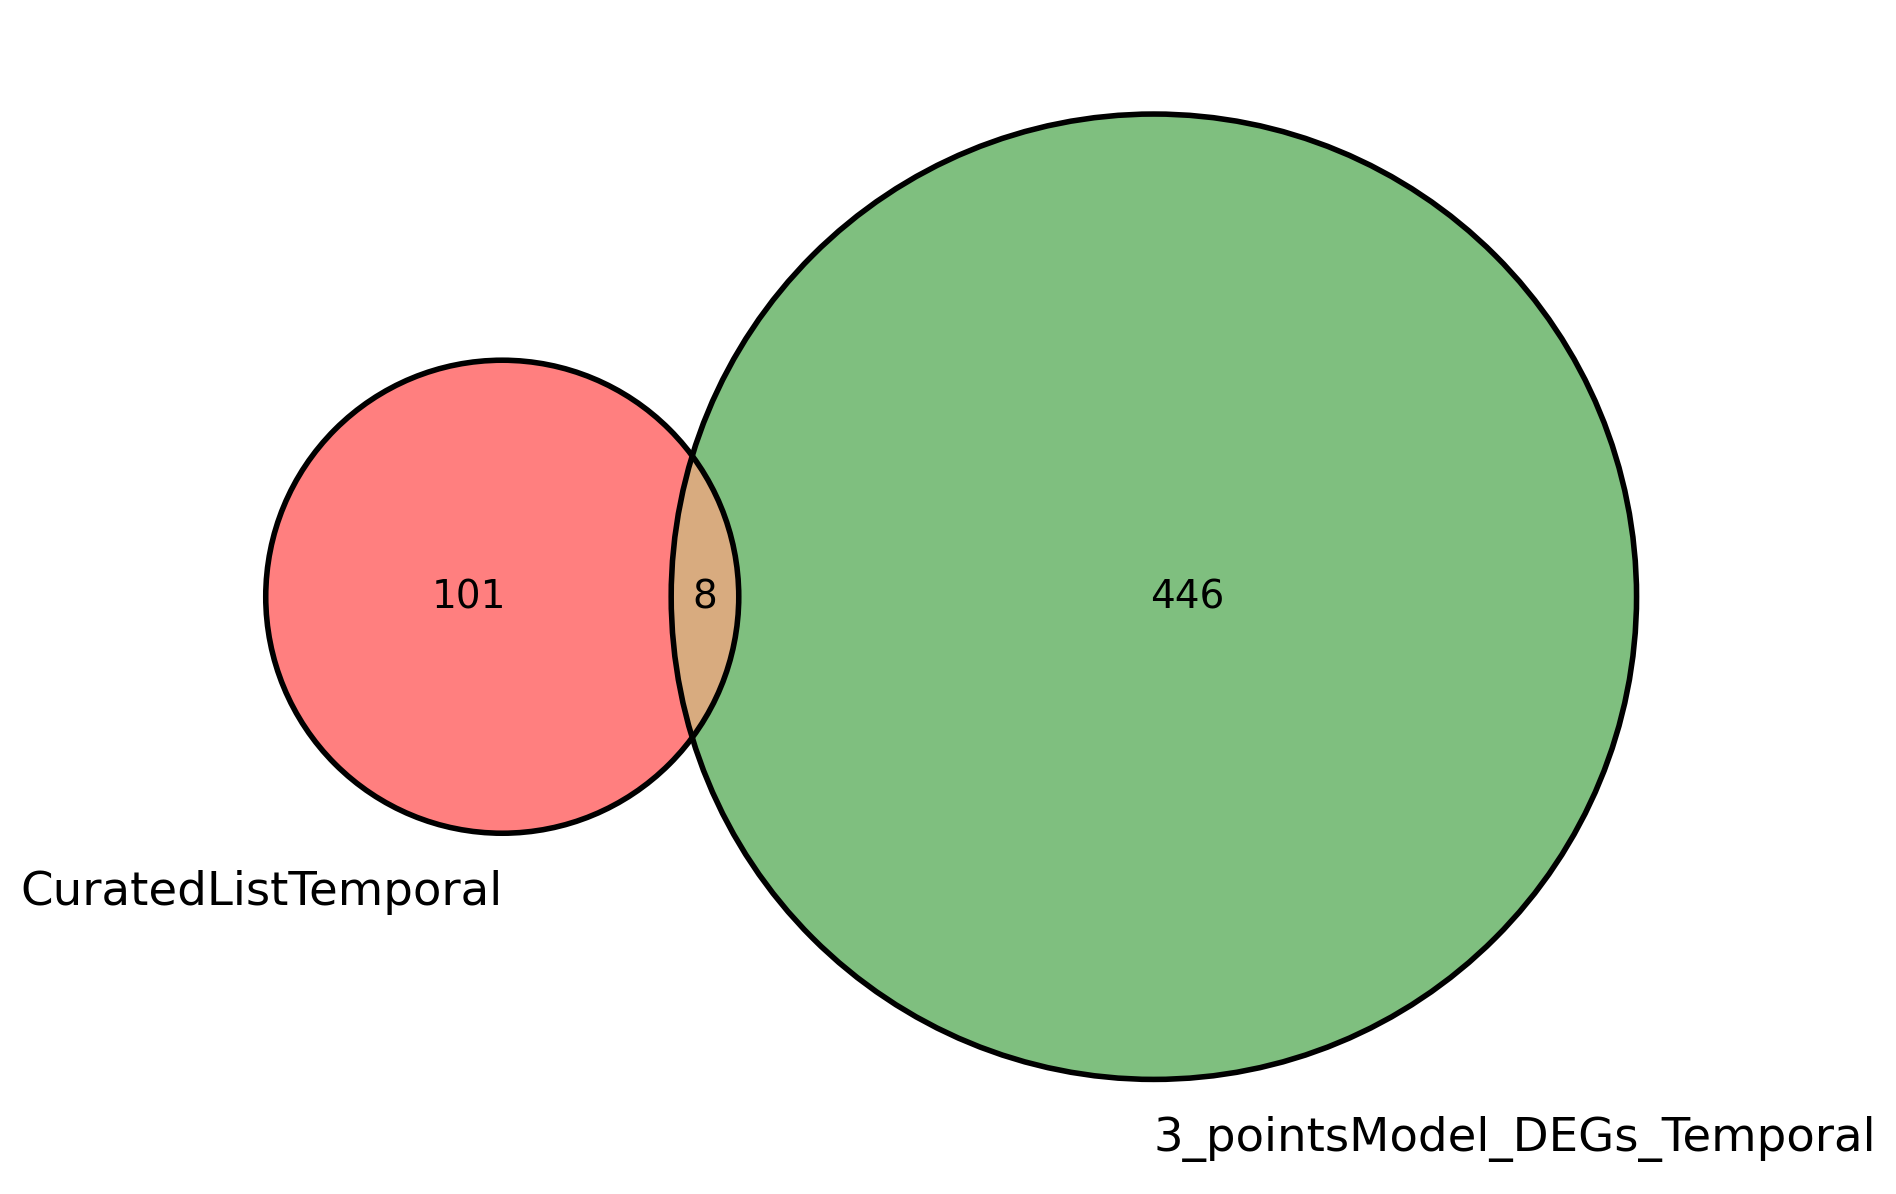

In [49]:
A = len(set(temporalMarkers).difference(set(temporalDEGs)))
B = len(set(temporalDEGs).difference(set(temporalMarkers)))
C = len(set(temporalMarkers).intersection(set(temporalDEGs)))

venn2(subsets = (A,B,C), set_labels = ('CuratedListTemporal', '3_pointsModel_DEGs_Temporal'), set_colors=('r', 'g'), alpha = 0.5);
venn2_circles(subsets = (A,B,C))



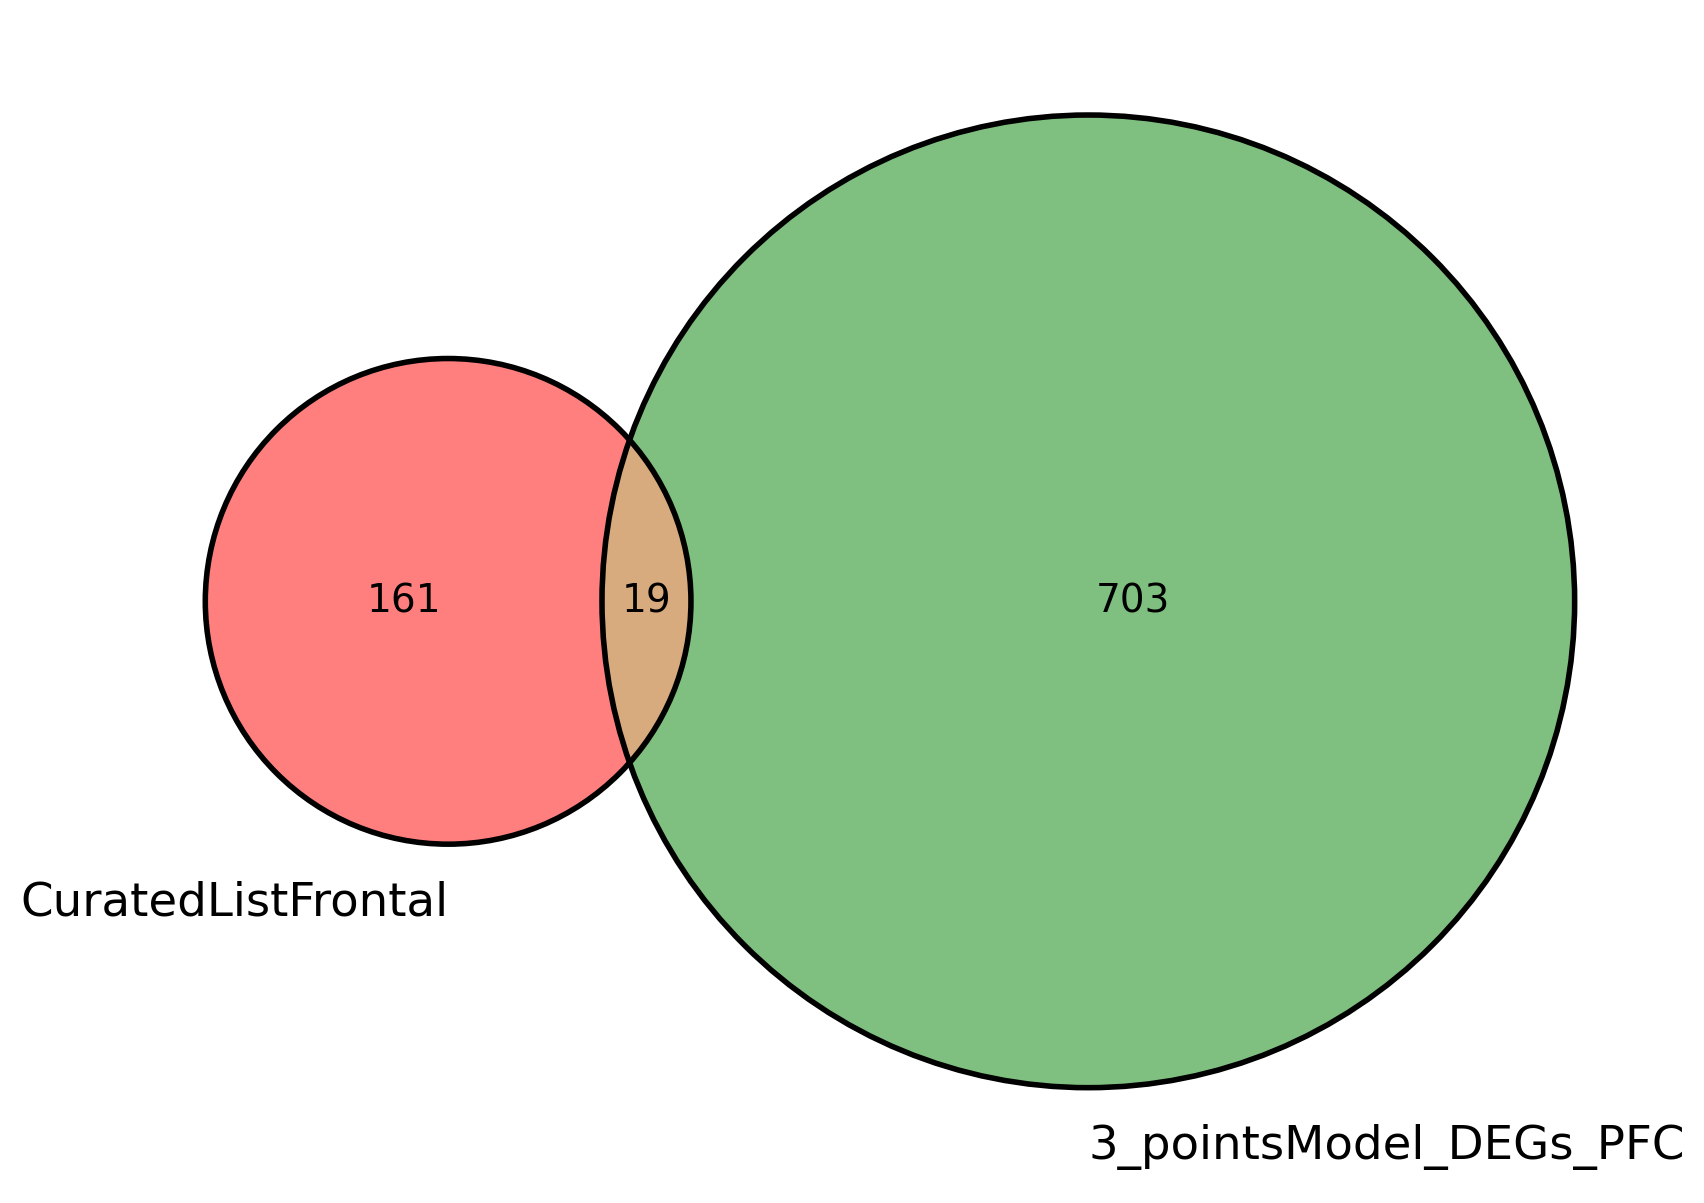

In [50]:
A = len(set(frontalMarkers).difference(set(frontalDEGs)))
B = len(set(frontalDEGs).difference(set(frontalMarkers)))
C = len(set(frontalMarkers).intersection(set(frontalDEGs)))

venn2(subsets = (A,B,C), set_labels = ('CuratedListFrontal', '3_pointsModel_DEGs_PFC'), set_colors=('r', 'g'), alpha = 0.5);
venn2_circles(subsets = (A,B,C))

In [51]:
PFC_vs_Temporaldf.to_csv(outdir+FinaLeaf+"/"+outputBaseName+".DEGs.tsv",sep = "\t")
PFC_vs_Temporaldf.to_excel(outdir+FinaLeaf+"/"+outputBaseName+".DEGs.xls")

# ROC

In [52]:
evidence = 0
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets, metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
random_state = np.random.RandomState(0)
from scipy.misc import derivative
from scipy.optimize import curve_fit
from scipy.spatial import distance


def expPlateau(x,k):
    y=1 -(1-0)*np.exp(-k*x)  
    return(y)

def powerFun(x,a,b):
    y=a*x**b
    return(y)

markersDF = pd.read_csv(markers, header=None, sep = "\t", names=["name","area","score"])
markersDF = markersDF[markersDF.score > evidence]
markers_temporal = markersDF[markersDF.area=="Temporal"].name.tolist()
markers_frontal = markersDF[markersDF.area=="Frontal"].name.tolist()

PFC_vs_Temporaldf = pd.read_csv(outdir+FinaLeaf+"/"+outputBaseName+".DEGs.tsv",sep = "\t", index_col=0)
PFC_vs_Temporaldf_Up = PFC_vs_Temporaldf[PFC_vs_Temporaldf.logFC > 0]
PFC_vs_Temporaldf_Down = PFC_vs_Temporaldf[PFC_vs_Temporaldf.logFC < 0]


PFC_vs_Temporaldf_Down["TruePos"] = np.where(PFC_vs_Temporaldf_Down.genes.isin(markers_temporal), 1, 0)
PFC_vs_Temporaldf_Down = PFC_vs_Temporaldf_Down[["FWER","TruePos"]]
PFC_vs_Temporaldf_Down["logFWER"] = -np.log1p(PFC_vs_Temporaldf_Down["FWER"])


PFC_vs_Temporaldf_Up["TruePos"] = np.where(PFC_vs_Temporaldf_Up.genes.isin(markers_frontal), 1, 0)
PFC_vs_Temporaldf_Up = PFC_vs_Temporaldf_Up[["FWER","TruePos"]]
PFC_vs_Temporaldf_Up["logFWER"] = -np.log1p(PFC_vs_Temporaldf_Up["FWER"])

#PFC_vs_Temporaldf_Down.genes.isin(markersDF_temporal)

# Frontal genes

177
6
{'VSTM2L', 'S100A16', 'S100A13', 'RPRM', 'SLN', 'FABP7'}


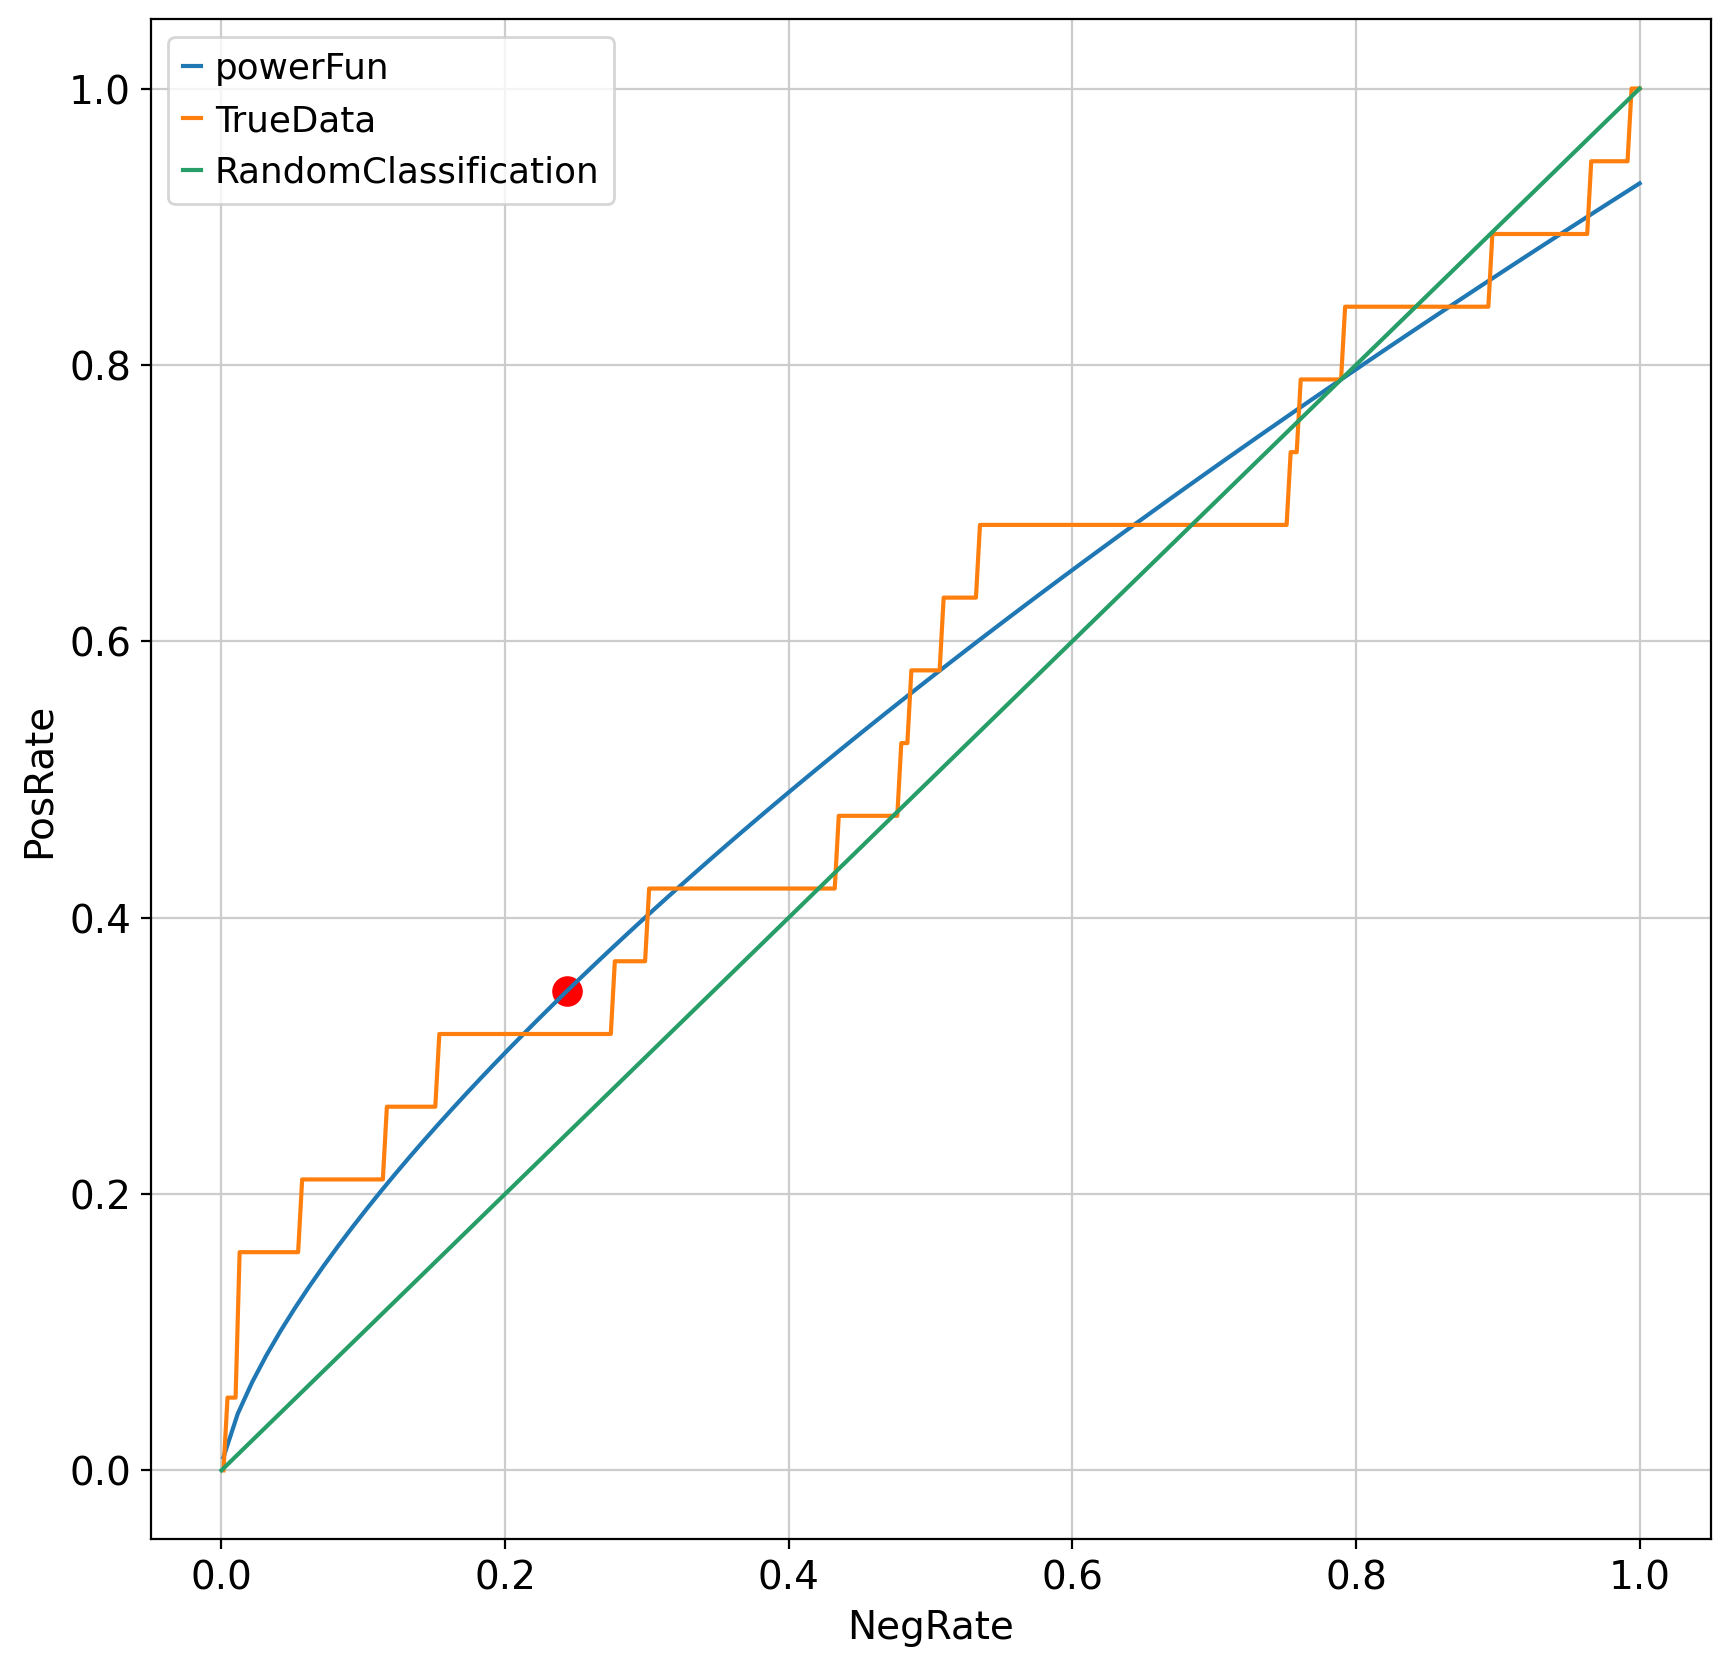

In [53]:
TotalNeg = (PFC_vs_Temporaldf_Up.TruePos == 0).sum()
TotalPos = (PFC_vs_Temporaldf_Up.TruePos == 1).sum()

ThresholdDF = pd.DataFrame()

for i in pd.Series(PFC_vs_Temporaldf_Up.FWER).drop_duplicates().tolist():
    Neg = (PFC_vs_Temporaldf_Up.loc[PFC_vs_Temporaldf_Up["FWER"] <= i,"TruePos"] == 0).sum()
    Pos = (PFC_vs_Temporaldf_Up.loc[PFC_vs_Temporaldf_Up["FWER"] <= i,"TruePos"] == 1).sum()    
    PosRate = Pos/TotalPos
    NegRate = Neg/TotalNeg    
    row = pd.DataFrame({"Threshold":i,"PosRate":PosRate,"NegRate":NegRate}, index = [0])
                 
    ThresholdDF = pd.concat([ThresholdDF,row], axis = 0, ignore_index=True)
    
    

continous_cuntSpace = np.linspace(min(ThresholdDF["NegRate"]), max(ThresholdDF["NegRate"]), 100)


fittedParams = curve_fit(powerFun, ThresholdDF["NegRate"],ThresholdDF["PosRate"])[0]


distanceFromDiag = []
for i in list(range(len(continous_cuntSpace))):
    fittedY = powerFun(continous_cuntSpace, *fittedParams)[i]
    diagPosition = continous_cuntSpace[i]
    sign = 1 if fittedY - diagPosition >= 0 else -1
    pointDistance = distance.euclidean([diagPosition, fittedY],[diagPosition, diagPosition ])*sign
    distanceFromDiag.append(pointDistance)

#sns.lineplot(continous_cuntSpace, expPlateau(continous_cuntSpace, *curve_fit(expPlateau, list(fpr), list(tpr))[0]), label="logFun")
sns.lineplot(continous_cuntSpace, powerFun(continous_cuntSpace, *fittedParams), label="powerFun")
sns.lineplot(ThresholdDF["NegRate"], ThresholdDF["PosRate"], ci=None,label="TrueData")
plt.scatter(continous_cuntSpace[np.argmax(distanceFromDiag)], 
            powerFun(continous_cuntSpace[np.argmax(distanceFromDiag)], *fittedParams), 
            marker='o', s=100, c="r")
#plt.axvline(continous_cuntSpace[np.argmax(distanceFromDiag)], color='b')

sns.lineplot([0,1], [0,1], ci=None,label="RandomClassification")

threshold = ThresholdDF[ThresholdDF.NegRate <= continous_cuntSpace[np.argmax(distanceFromDiag)]].Threshold.max()

#ActualFilter
PFC_vs_Temporaldf_UpFilt = PFC_vs_Temporaldf_Up[PFC_vs_Temporaldf_Up.FWER <= threshold].index.tolist()

print(len(PFC_vs_Temporaldf_UpFilt))
print(len(set(PFC_vs_Temporaldf_UpFilt).intersection(markers_frontal)))
print(set(PFC_vs_Temporaldf_UpFilt).intersection(markers_frontal))

# Temporal genes

98
4
{'FGFR3', 'LHX2', 'NR2F2', 'NR2F1'}


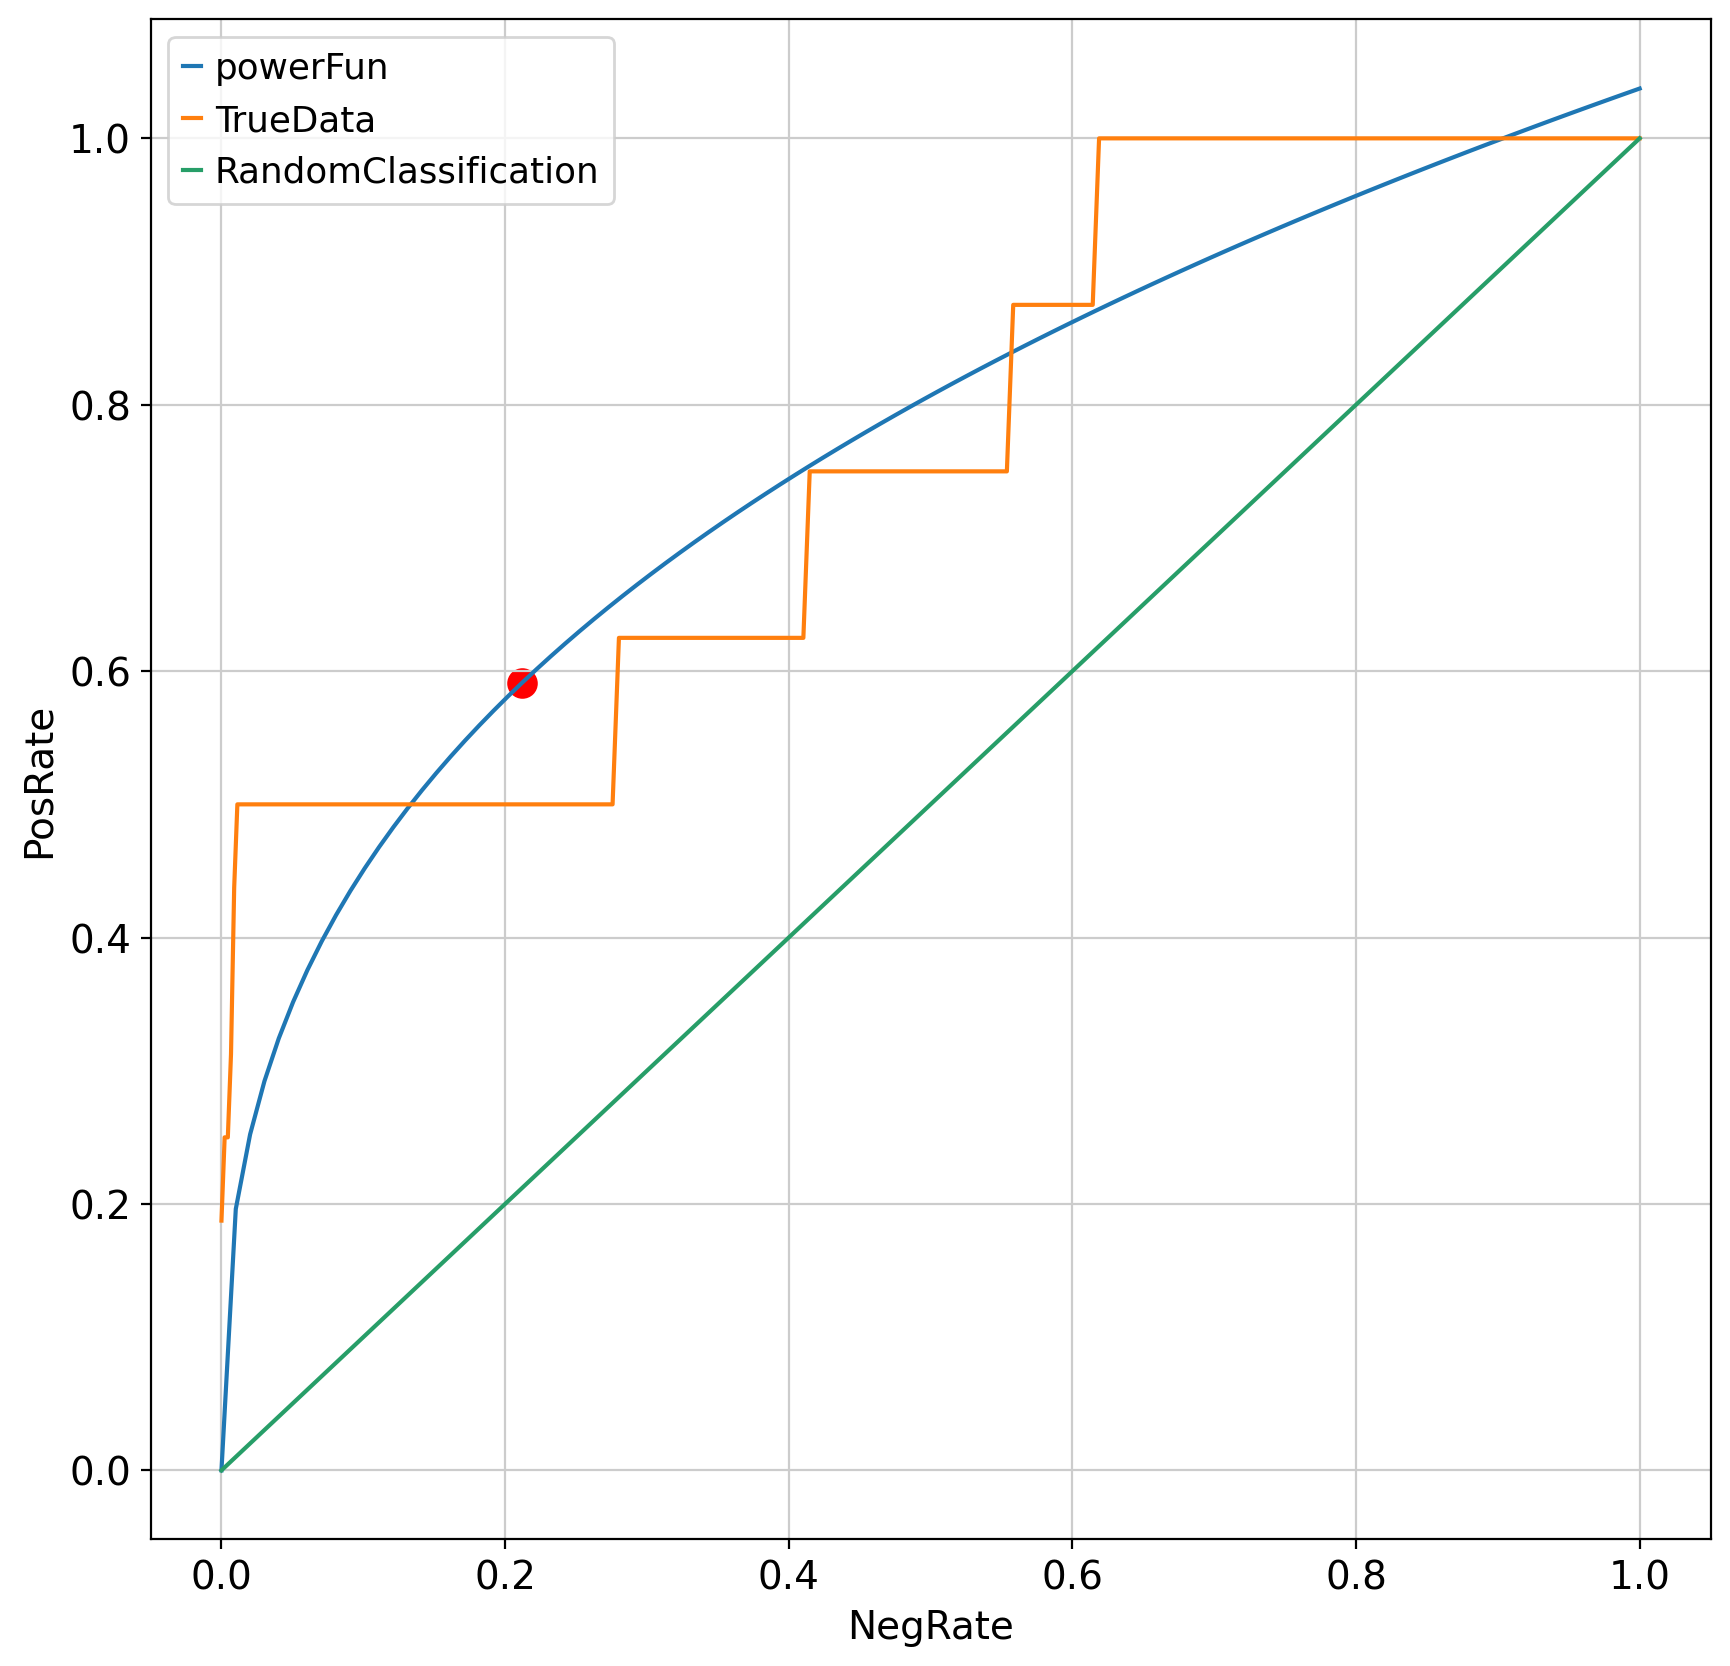

In [54]:
TotalNeg = (PFC_vs_Temporaldf_Down.TruePos == 0).sum()
TotalPos = (PFC_vs_Temporaldf_Down.TruePos == 1).sum()

ThresholdDF = pd.DataFrame()

for i in pd.Series(PFC_vs_Temporaldf_Down.FWER).drop_duplicates().tolist():
    Neg = (PFC_vs_Temporaldf_Down.loc[PFC_vs_Temporaldf_Down["FWER"] <= i,"TruePos"] == 0).sum()
    Pos = (PFC_vs_Temporaldf_Down.loc[PFC_vs_Temporaldf_Down["FWER"] <= i,"TruePos"] == 1).sum()    
    PosRate = Pos/TotalPos
    NegRate = Neg/TotalNeg    
    row = pd.DataFrame({"Threshold":i,"PosRate":PosRate,"NegRate":NegRate}, index = [0])
                 
    ThresholdDF = pd.concat([ThresholdDF,row], axis = 0, ignore_index=True)
    
    

continous_cuntSpace = np.linspace(min(ThresholdDF["NegRate"]), max(ThresholdDF["NegRate"]), 100)


fittedParams = curve_fit(powerFun, ThresholdDF["NegRate"],ThresholdDF["PosRate"])[0]

distanceFromDiag = []
for i in list(range(len(continous_cuntSpace))):
    fittedY = powerFun(continous_cuntSpace, *fittedParams)[i]
    diagPosition = continous_cuntSpace[i]
    sign = 1 if fittedY - diagPosition >= 0 else -1
    pointDistance = distance.euclidean([diagPosition, fittedY],[diagPosition, diagPosition ])*sign
    distanceFromDiag.append(pointDistance)
    
#sns.lineplot(continous_cuntSpace, expPlateau(continous_cuntSpace, *curve_fit(expPlateau, list(fpr), list(tpr))[0]), label="logFun")
sns.lineplot(continous_cuntSpace, powerFun(continous_cuntSpace, *fittedParams), label="powerFun")
sns.lineplot(ThresholdDF["NegRate"], ThresholdDF["PosRate"], ci=None,label="TrueData")
plt.scatter(continous_cuntSpace[np.argmax(distanceFromDiag)], 
            powerFun(continous_cuntSpace[np.argmax(distanceFromDiag)], *fittedParams), 
            marker='o', s=100, c="r")
#plt.axvline(continous_cuntSpace[np.argmax(distanceFromDiag)], color='b')

sns.lineplot([0,1], [0,1], ci=None,label="RandomClassification")

threshold = ThresholdDF[ThresholdDF.NegRate <= continous_cuntSpace[np.argmax(distanceFromDiag)]].Threshold.max()

#ActualFilter
PFC_vs_Temporaldf_DownFilt = PFC_vs_Temporaldf_Down[PFC_vs_Temporaldf_Down.FWER <= threshold].index.tolist()

print(len(PFC_vs_Temporaldf_DownFilt))
print(len(set(PFC_vs_Temporaldf_DownFilt).intersection(markers_temporal)))
print(set(PFC_vs_Temporaldf_DownFilt).intersection(markers_temporal))

# Save filtered

In [55]:
PFC_vs_TemporaldfFilt = PFC_vs_Temporaldf[PFC_vs_Temporaldf.index.isin(PFC_vs_Temporaldf_DownFilt+PFC_vs_Temporaldf_UpFilt)]
PFC_vs_TemporaldfFilt.to_csv(outdir+FinaLeaf+"/"+outputBaseName+".DEGs.filtered.tsv",sep = "\t")
PFC_vs_TemporaldfFilt.to_excel(outdir+FinaLeaf+"/"+outputBaseName+".DEGs.filtered.xls")

In [56]:
PFC_vs_TemporaldfFilt.sort_values("logFC")

,genes,entrez,logFC,logCPM,LR,PValue,FWER
NR2F2,NR2F2,6013.0,-17.726750,4.643613,625.162267,5.636251e-138,9.968837e-134
FGFR3,FGFR3,51596.0,-13.019130,4.253947,445.840611,5.798599e-99,1.025598e-94
THORLNC,THORLNC,858.0,-7.837909,3.310107,90.266518,2.081453e-21,3.681466e-17
NR2F1,NR2F1,7458.0,-7.661204,7.921461,2245.214204,0.000000e+00,0.000000e+00
DIPK1C,DIPK1C,6210.0,-7.212827,4.075935,157.154754,4.735156e-36,8.375071e-32
...,...,...,...,...,...,...,...
LAMP5,LAMP5,26071.0,8.852229,4.880389,462.760467,1.205507e-102,2.132181e-98
S100A16,S100A16,369.0,10.492386,5.008513,666.341510,6.240536e-147,1.103764e-142
VSTM2L,VSTM2L,51097.0,13.788597,3.109846,171.743369,3.078991e-39,5.445811e-35
CYP26A1,CYP26A1,90139.0,15.207455,2.678664,112.380819,2.948677e-26,5.215324e-22
